## Load the dataset and create the medium

In [1]:
import cobra
model = cobra.io.load_json_model("H:/ROBOT_SCIENTIST/E_coli/iML1515.json")
model

<Model iML1515 at 0x232c959d908>

In [2]:
import cobra
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

def run(per_strain: bool = True,
        strain:str = "WT",
        replication:str = "no_replicates",
        gr_column:str = "mv_mu_max",
        experiment:str = "mediabotJLF2",
        ):
    model = cobra.io.load_json_model("H:/ROBOT_SCIENTIST/E_coli/iML1515.json")
    
    if per_strain:
        exp_data_path = f"H:/ROBOT_SCIENTIST/E_coli/Growth_rates/2025-10-31-27/processed/{replication}_STRAINS/{strain}/AMN_dataset/"
        growth_data_path = f"H:/ROBOT_SCIENTIST/E_coli/Growth_rates/2025-10-31-27/processed/{replication}_STRAINS/{strain}/"
    else:
        exp_data_path = f"H:/ROBOT_SCIENTIST/E_coli/Growth_rates/2025-10-31-27/processed/{replication}/{experiment}/AMN_dataset/"
        growth_data_path = f"H:/ROBOT_SCIENTIST/E_coli/Growth_rates/2025-10-31-27/processed/{replication}/{experiment}/"
    # 
    exp_data = pd.read_csv(exp_data_path + "df_flux.csv") 
    growth_data = pd.read_csv(growth_data_path + "growth_rates.csv")
    
    # Filter growth_data to match the rows in exp_data 
    # Since exp_data was created from growth_data where success=='ok', we need to apply the same filter
    # OR simply take the first len(exp_data) rows if they're already aligned
    growth_data = growth_data.reset_index(drop=True)
    growth_data = growth_data.loc[growth_data['success'], :]
    exp_data = exp_data.reset_index(drop=True)        
    # Remove growth rate column from growth_data to avoid duplicates
    growth_data = growth_data.drop(columns=[gr_column])                
    # Now join them - they should have the same number of rows
    combinded_data = pd.concat([exp_data.reset_index(drop=True), growth_data.reset_index(drop=True)],
                                axis=1)

    def update_uracil(val):
        for part in ["_0.5", "_22.4", "_200", "_2", "_8", "_64", "_640", "0"]:
             val = val.replace(part, "")
        return val
    combinded_data["supplements_unified"] = combinded_data["supplements"].apply(lambda x: update_uracil(str(x)) if pd.notna(x) else x)
    
    def classify(val):
        """Classify supplements into Sugar, Nucleo, Amino based on content"""
        if pd.isna(val) or str(val).lower() == 'nan' or str(val).strip() == '':
            return 'None'
        
        # Split by semicolon and convert to lowercase for comparison
        parts = str(val).lower().split(';')
        parts = [p.strip() for p in parts if p.strip()]
        
        if not parts:
            print(val)
            return 'None'
        
        # Define categories (all lowercase)
        sugars = ['glucose', 'succinate', 'sucrose', 'galactose', 'fructose', 'mannose',
                  'maltose', 'lactose', 'xylose', 'arabinose', 'ribose']
        
        nucleobases = ['adenine', 'uracil', 'guanine', 'cytosine', 'thymine']
        
        # Amino acids are typically 3 letters (all lowercase)
        amino_acids_3letter = ['ala', 'arg', 'asn', 'asp', 'cys', 'gln', 'glu', 'gly',
                               'his', 'ile', 'leu', 'lys', 'met', 'phe', 'pro', 'ser',
                               'thr', 'trp', 'tyr', 'val']
        
        categories = []
        for part in parts:
            # Check if it's a sugar
            if any(sugar in part for sugar in sugars):
                if 'Sugar' not in categories:
                    categories.append('Sugar')
            # Check if it's a nucleobase
            elif any(nucleo in part for nucleo in nucleobases):
                if 'Nucleo' not in categories:
                    categories.append('Nucleo')
            # Check if it's a 3-letter amino acid or contains common amino acid patterns
            elif any(aa in part for aa in amino_acids_3letter) or len(part) == 3:
                if 'Amino' not in categories:
                    categories.append('Amino')
        
        if not categories:
            return 'Other'
        
        # Sort to ensure consistent ordering
        categories.sort()
        return '+'.join(categories)
    
    combinded_data["group"] = combinded_data["supplements_unified"].apply(classify)
    #===============================
    preds = []
    status = []
    for _, row in exp_data.iterrows():
        with model:
            # Set the medium according to the experimental data
            medium = model.medium.copy()
            for rxn_id in medium:
                medium[rxn_id] = 0.0  # Set high uptake rates for all exchange reactions
            for rxn_id in exp_data.columns:
                if rxn_id != gr_column:
                    medium[rxn_id] = row.get(rxn_id, 0.0)  # Set uptake rates based on experimental data
            model.medium = medium
            # Perform FBA
            # model.objective = 'BIOMASS_Ec_iML1515_WT_75p37M'
            model.objective = 'BIOMASS_Ec_iML1515_core_75p37M'                
            solution = model.optimize()        
            preds.append(solution.objective_value)
            status.append(solution.status  == 'optimal')
            # if solution.status != 'optimal':
            #     print("=" * 40, "\n", f"faild solution \n{row}", "\n", "=" * 40)
    #
    # remove outtiers from predictions
    preds_array = np.array(preds)
    status_array = np.array(status)
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    percentile_lower = 0#5
    percentile_upper = 100#75
    q1 = np.percentile(preds_array, percentile_lower)
    q3 = np.percentile(preds_array, percentile_upper)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    filtered_preds = [pred if lower_bound <= pred <= upper_bound else np.nan for pred in preds_array]
    filtered_status = [status_array[i] if lower_bound <= preds_array[i] <= upper_bound else False for i in range(len(preds_array))]
    #
    masks = [s for s in filtered_status]
    fig = plt.figure(figsize=(16,6))

    ax1, ax2, ax3 = fig.subplots(1,3)
    
    # Get filtered data for plotting
    y = np.array([p for p, m in zip(filtered_preds, masks) if m])
    x = np.array(combinded_data[gr_column][masks])

    # Get supplement groups for color coding
    groups = combinded_data['group'][masks].astype(str).values  
    unique_groups = np.unique(groups)
    n_groups = len(unique_groups)
    
    # Use a colormap with distinct colors
    if n_groups <= 10:
        colors = plt.cm.tab10(np.linspace(0, 1, 10))[:n_groups]
    elif n_groups <= 20:
        colors = plt.cm.tab20(np.linspace(0, 1, 20))[:n_groups]
    else:
        colors = plt.cm.gist_rainbow(np.linspace(0, 1, n_groups))
    
    # Create color map for supplements
    group_colors = {supp: colors[i] for i, supp in enumerate(unique_groups)}
    
    # Plot each supplement group with its own color
    for supp in unique_groups:
        supp_mask = groups == supp
        ax1.scatter(x[supp_mask], y[supp_mask], 
                   color=group_colors[supp], 
                   label=supp, 
                   alpha=0.7, 
                   s=50,
                   edgecolors='black',
                   linewidths=0.5)
    
    # Add legend
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, 
              title='Supplement', framealpha=0.9)
    m, b = np.polyfit(x, y, 1)
    ax1.plot(x, m*x + b, color='red', label=f'y={m:.2f}x+{b:.2f}')
    # find R2
    correlation_matrix = np.corrcoef(x, y)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    ax1.set_xlabel("Experimental growth rates")
    ax1.set_ylabel("FBA predicted growth rates")
    if per_strain:
        subtitle= (f"Strain:{strain}, "
                   f"\n Data points n:{sum(masks)}, Q1:%{percentile_lower}-Q2:%{percentile_upper}")
    else:
        subtitle= (f"experiment:{experiment},  "
                   f"\n Data points n:{sum(masks)}, Q1:%{percentile_lower}-Q2:%{percentile_upper}")
    ax1.set_title(f"(R²={r_squared:.4f}) \n"
              f"{subtitle}"
              )
    #==========================
    # residuals plots - also colored by supplement
    residuals = y - (m * x + b)
    for supp in unique_groups:
        supp_mask = groups == supp
        ax2.scatter(x[supp_mask], residuals[supp_mask], 
                   color=group_colors[supp], 
                   alpha=0.6,
                   s=50,
                   edgecolors='black',
                   linewidths=0.5)
    ax2.axhline(0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel("Experimental growth rates")
    ax2.set_ylabel("Residuals (Predicted - Experimental)")
    ax2.set_title("Residuals Plot")
    #==========================
    # residual distribution: histogram with stacked by supplement
    ax3.hist([residuals[groups == supp] for supp in unique_groups],
             label=[str(supp) for supp in unique_groups], # type: ignore
             color=[group_colors[supp] for supp in unique_groups], # type: ignore
             alpha=0.7,
             edgecolor='black',
             linewidth=0.5,
             stacked=False) # type: ignore
    ax3.legend(fontsize=8, title='Supplement')
    ax3.set_xlabel("Residuals")
    ax3.set_ylabel("Frequency")
    ax3.set_title("Residuals distribution.")
    #==========================

    average_type = "All data points" if replication == "no_replicates" else "OD average" if replication == "replicates" else "Growth rate average"
    plt.suptitle(f"Comparison of Experimental and FBA Predicted Growth Rates, replication:{average_type}")
    # plt.legend()
    plt.tight_layout()
    plt.show()

    #==========================
    # Create separate scatter plots for each supplement group with individual R²
    n_groups = len(unique_groups)
    n_cols = min(3, n_groups)
    n_rows = int(np.ceil(n_groups / n_cols))
    
    fig2, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_groups == 1:
        axes = np.array([axes])
    axes = axes.flatten() if n_groups > 1 else axes
    
    for idx, supp in enumerate(unique_groups):
        ax = axes[idx] if n_groups > 1 else axes[0]
        
        # Get data for this supplement group
        supp_mask = groups == supp
        x_supp = x[supp_mask]
        y_supp = y[supp_mask]
        
        # Get the individual supplements within this group for coloring
        supp_supplements = combinded_data['supplements_unified'][masks].values[supp_mask]
        unique_supps_in_group = np.unique(supp_supplements)
        n_supps_in_group = len(unique_supps_in_group)
        
        # Create color map for individual supplements within this group
        if n_supps_in_group <= 10:
            supp_colors_local = plt.cm.tab10(np.linspace(0, 1, 10))[:n_supps_in_group]
        elif n_supps_in_group <= 20:
            supp_colors_local = plt.cm.tab20(np.linspace(0, 1, 20))[:n_supps_in_group]
        else:
            supp_colors_local = plt.cm.gist_rainbow(np.linspace(0, 1, n_supps_in_group))
        
        supp_color_map = {s: supp_colors_local[i] for i, s in enumerate(unique_supps_in_group)}
        
        # Plot scatter with individual supplement colors
        for individual_supp in unique_supps_in_group:
            individual_mask = supp_supplements == individual_supp
            ax.scatter(x_supp[individual_mask], y_supp[individual_mask], 
                      color=supp_color_map[individual_supp], 
                      alpha=0.7, 
                      s=50,
                      edgecolors='black',
                      linewidths=0.5,
                      label=individual_supp)
        
        # Fit line and calculate R²
        if len(x_supp) > 1:
            m_supp, b_supp = np.polyfit(x_supp, y_supp, 1)
            ax.plot(x_supp, m_supp*x_supp + b_supp, 
                   color='red', 
                   linewidth=2,
                   label=f'y={m_supp:.2f}x+{b_supp:.2f}')
            
            # Calculate R²
            correlation_matrix_supp = np.corrcoef(x_supp, y_supp)
            correlation_xy_supp = correlation_matrix_supp[0,1]
            r_squared_supp = correlation_xy_supp**2
            
            ax.set_title(f'{supp}\nR²={r_squared_supp:.4f}, n={len(x_supp)}', 
                        fontsize=10, fontweight='bold')
        else:
            ax.set_title(f'{supp}\nn={len(x_supp)} (insufficient data)', 
                        fontsize=10)
        
        ax.set_xlabel("Experimental growth rates")
        ax.set_ylabel("FBA predicted growth rates")
        ax.grid(True, alpha=0.3)
        if len(x_supp) > 1:
            ax.legend(fontsize=6, ncol=2, loc='best')
    
    # Hide unused subplots
    for idx in range(n_groups, len(axes)):
        axes[idx].axis('off')
    
    fig2.suptitle(f'Individual Supplement Group Analysis - {strain if per_strain else experiment}, for {average_type}', 
                 fontsize=14, fontweight='bold')
    fig2.tight_layout()
    plt.show()





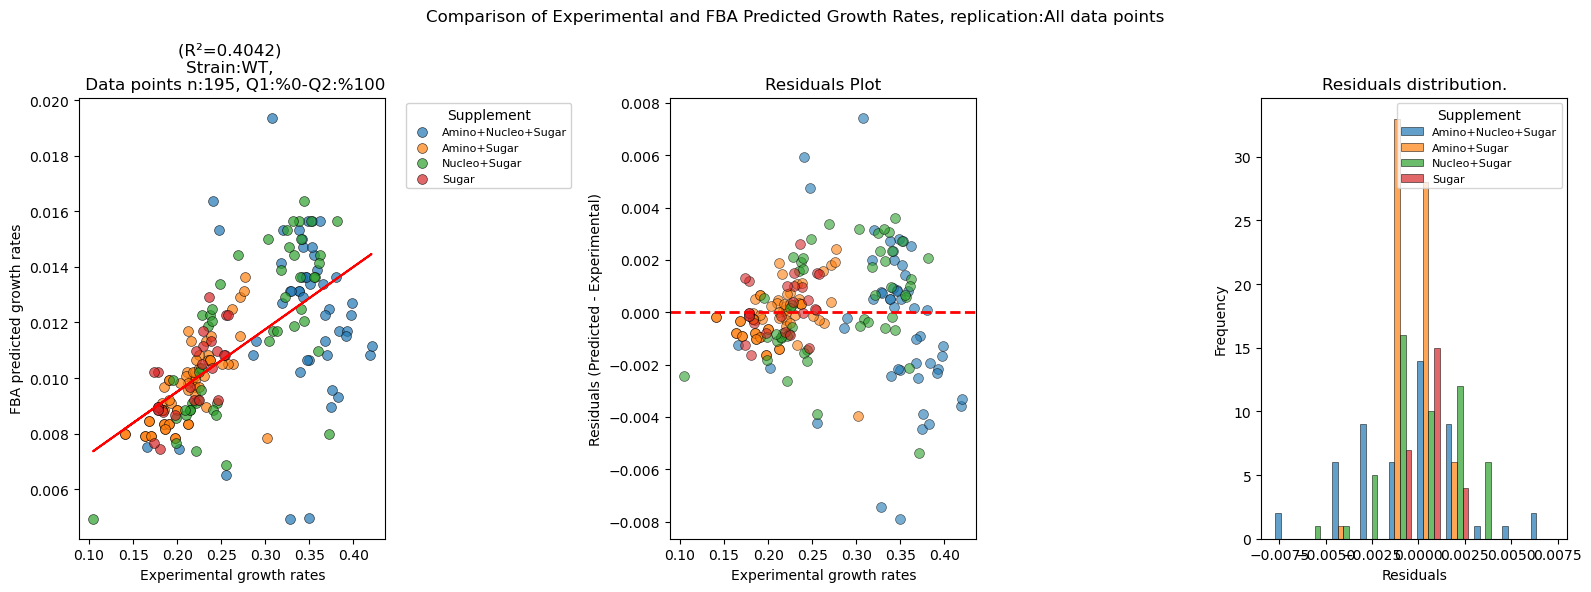

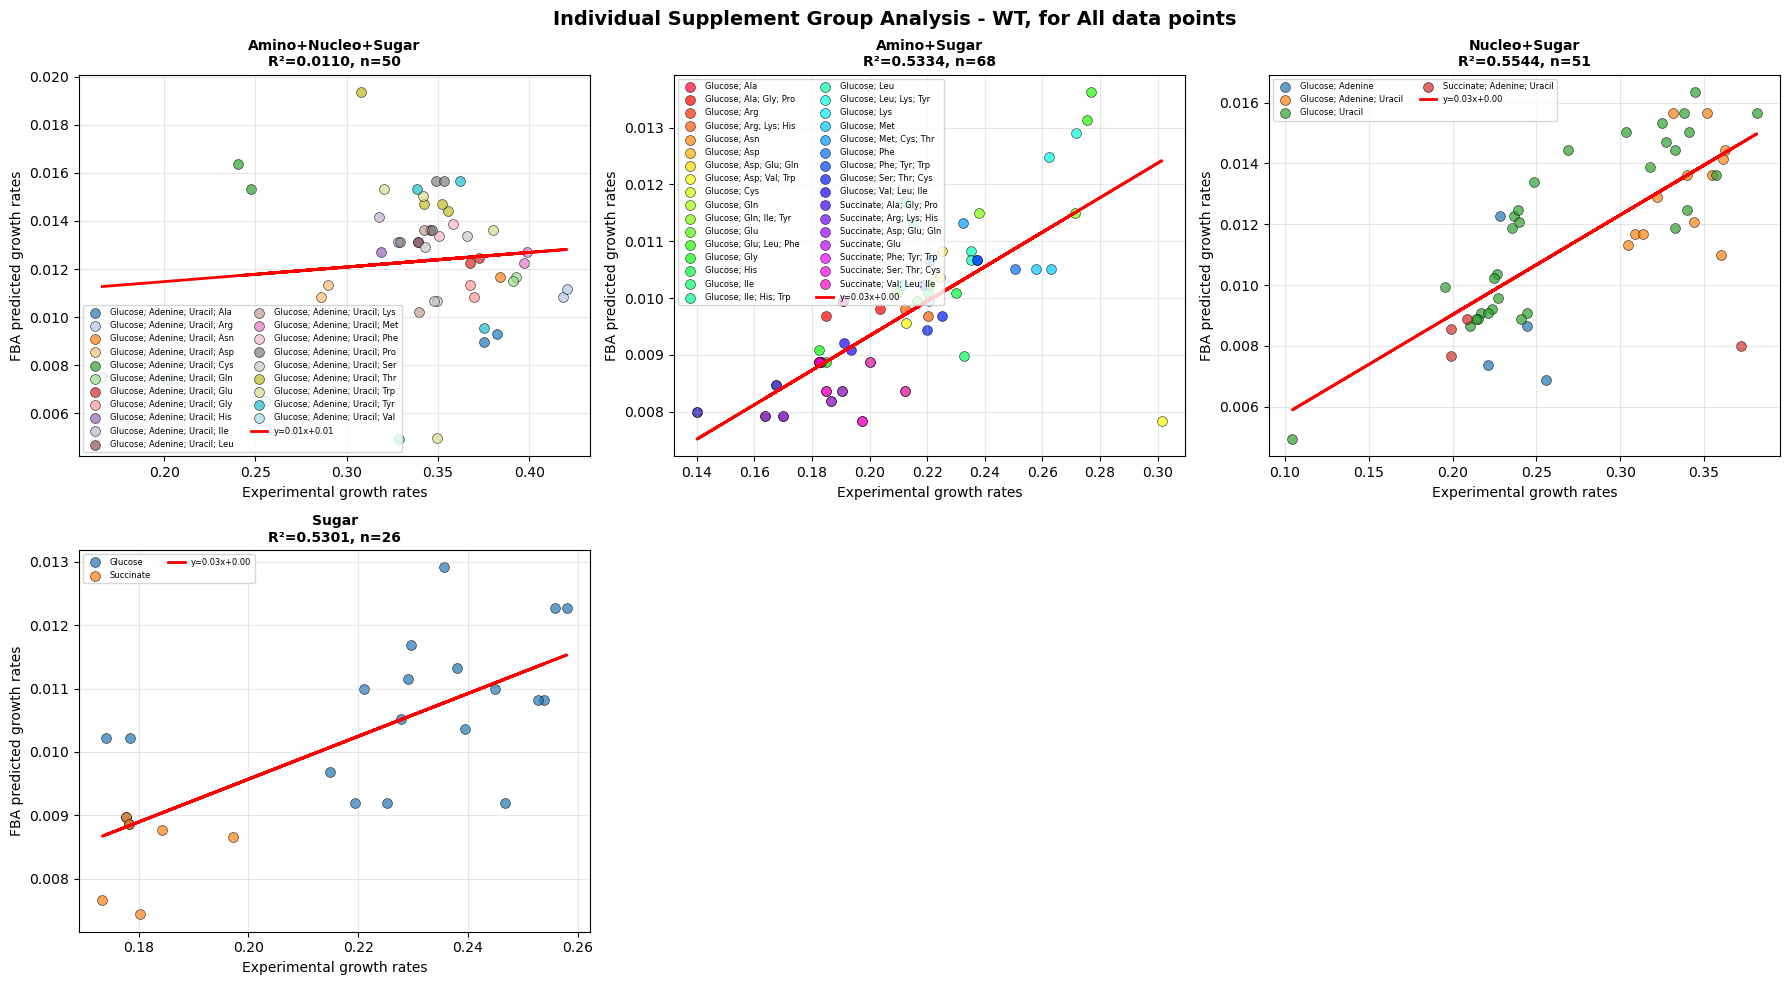

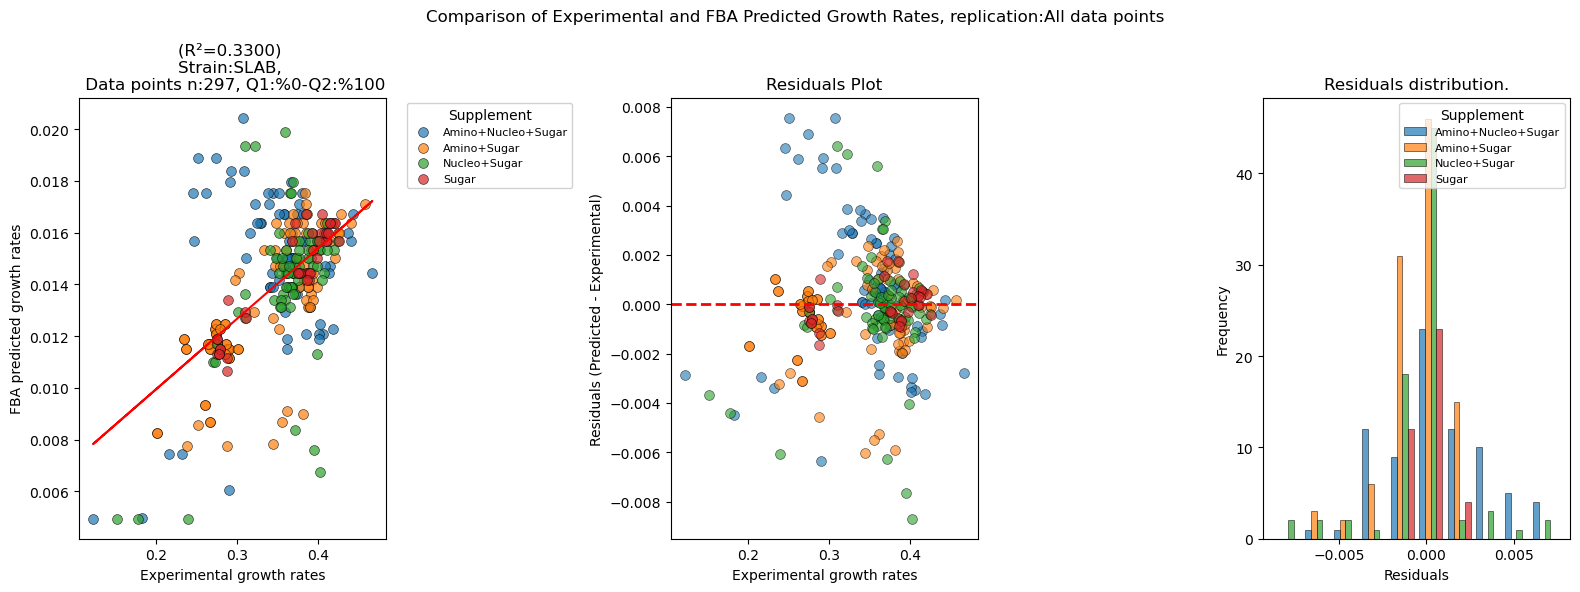

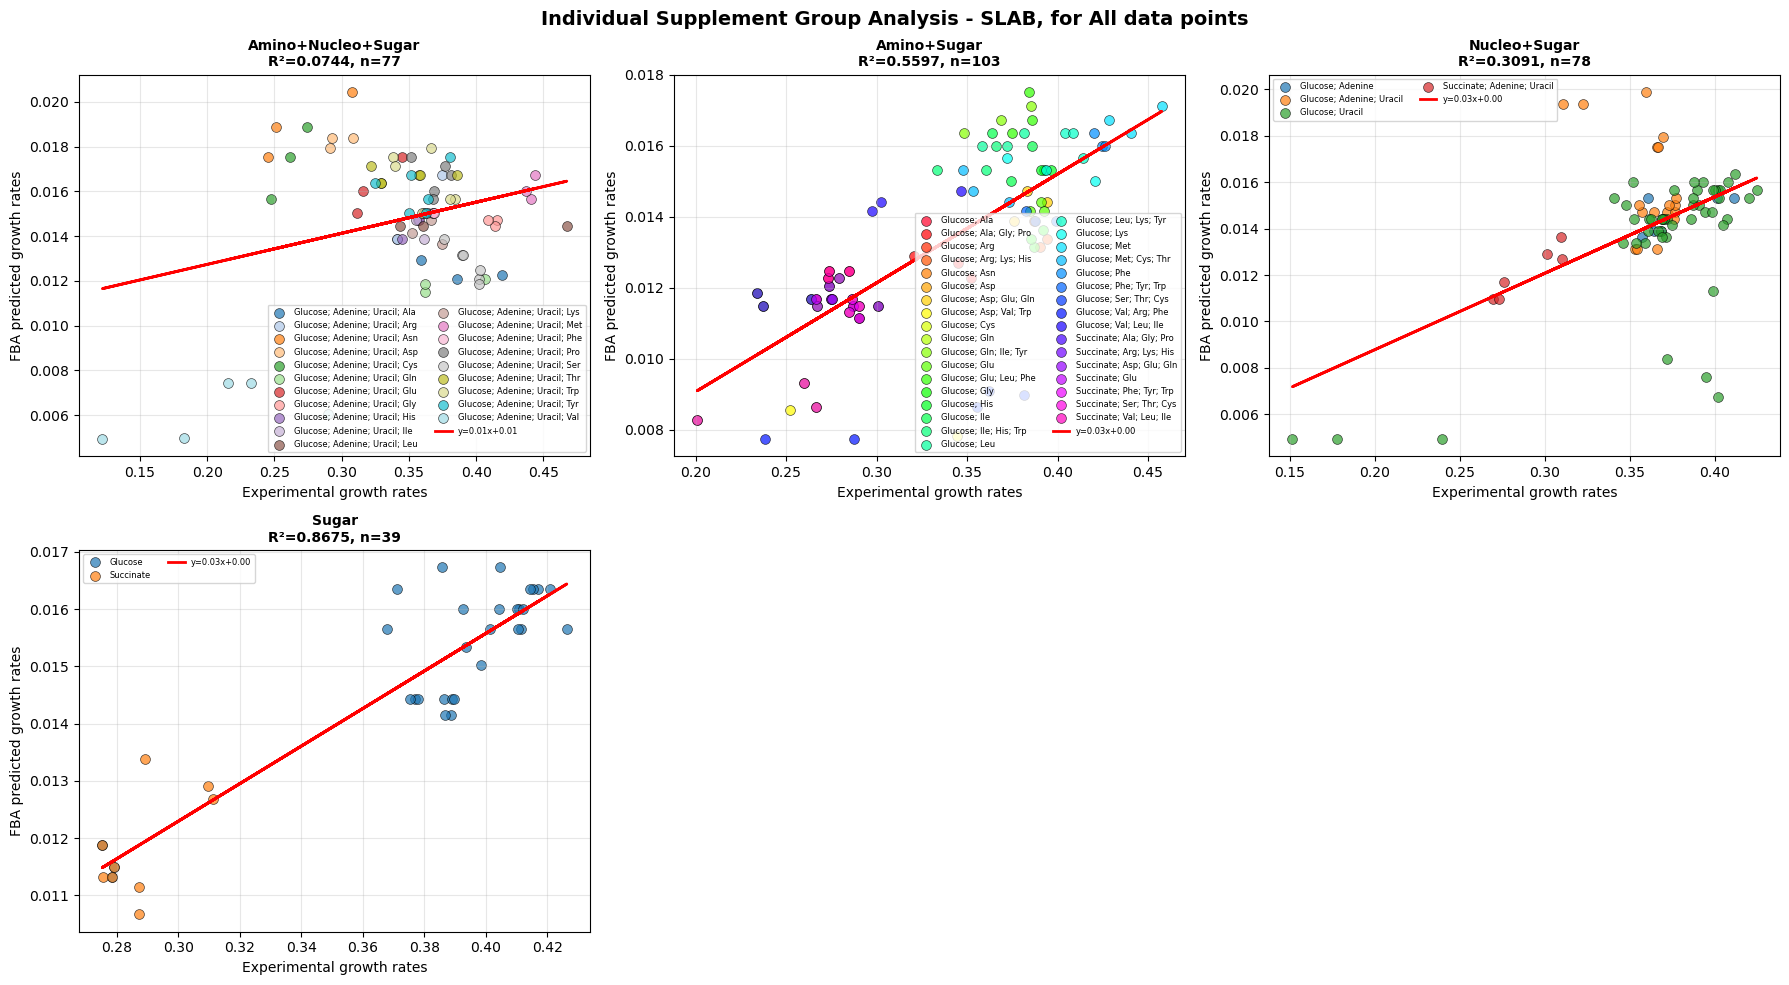

c:\Users\rh2310\projects\amn_release\.env\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


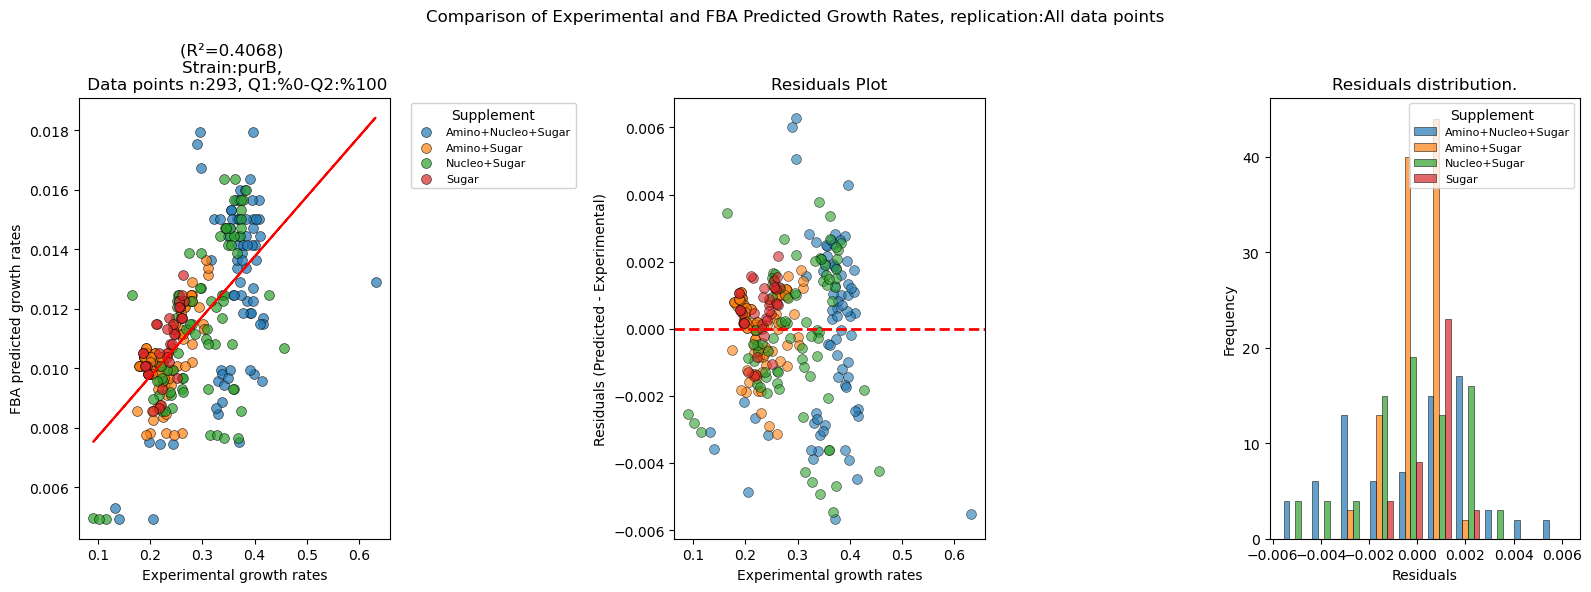

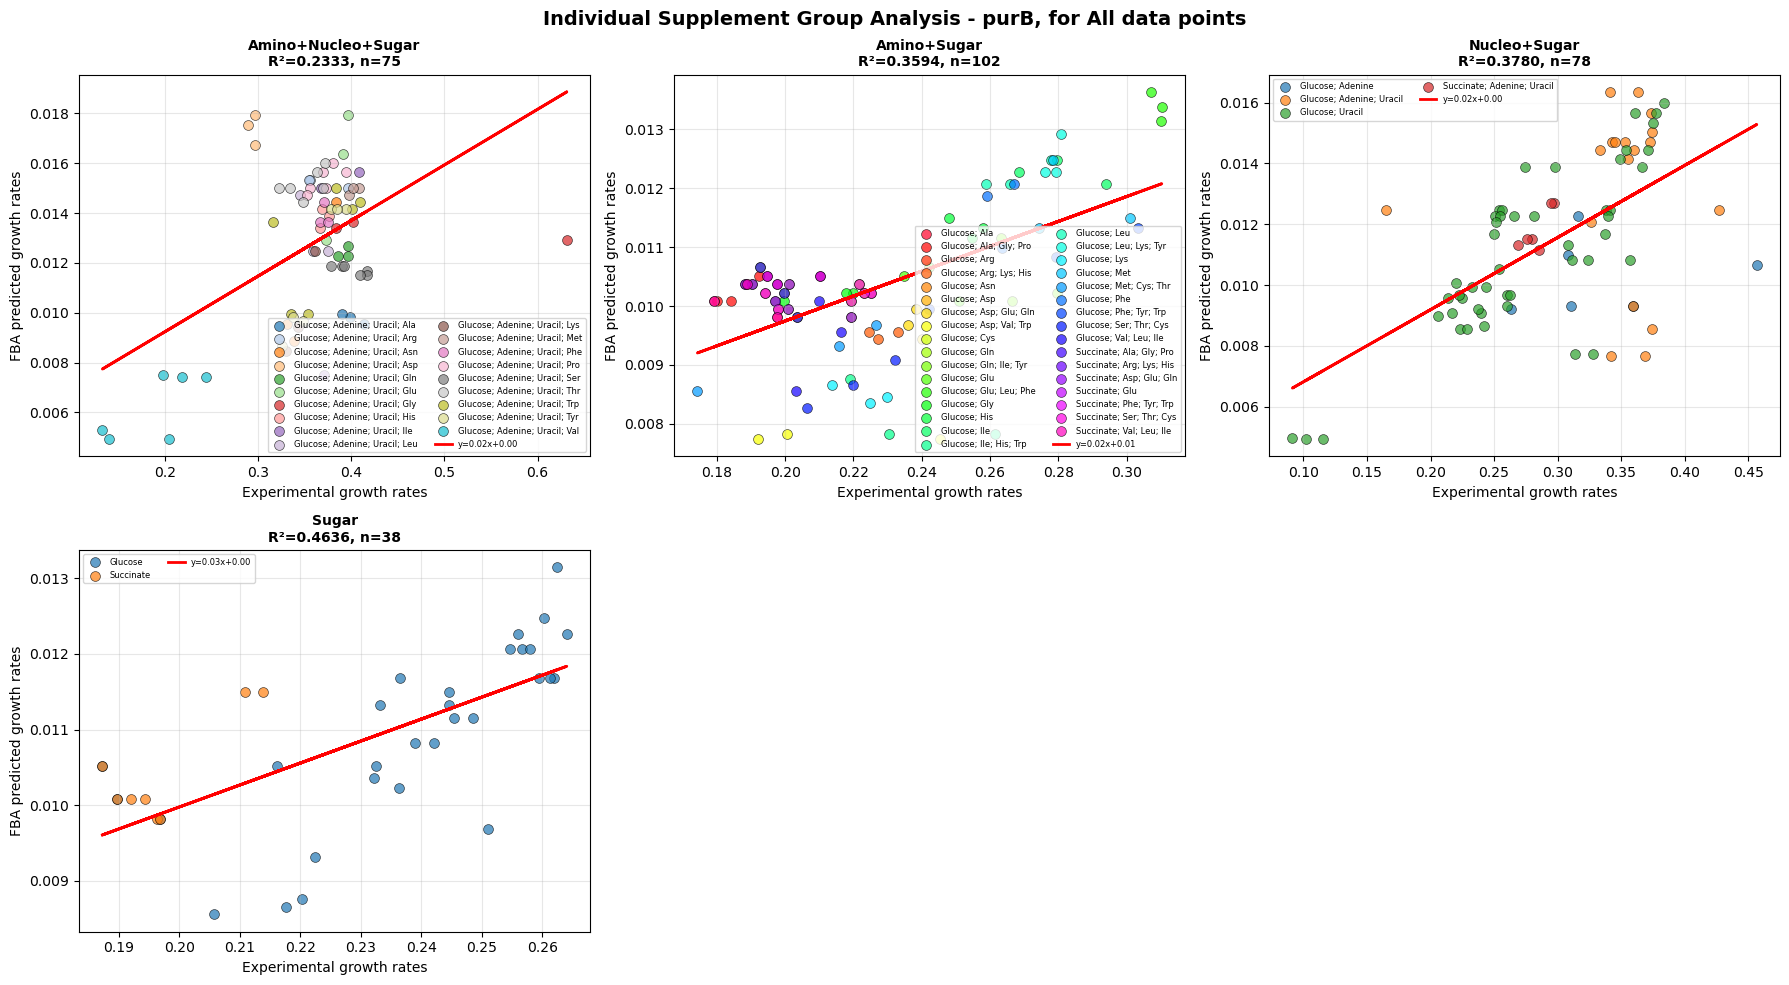

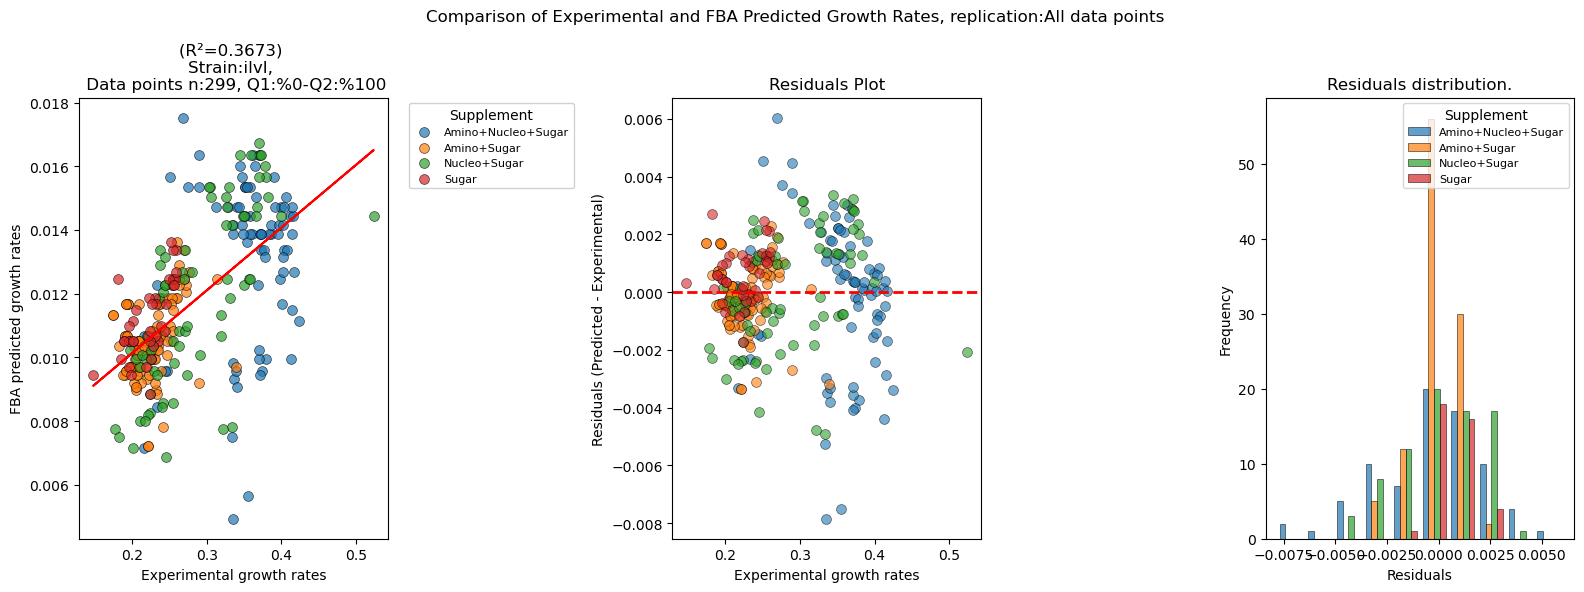

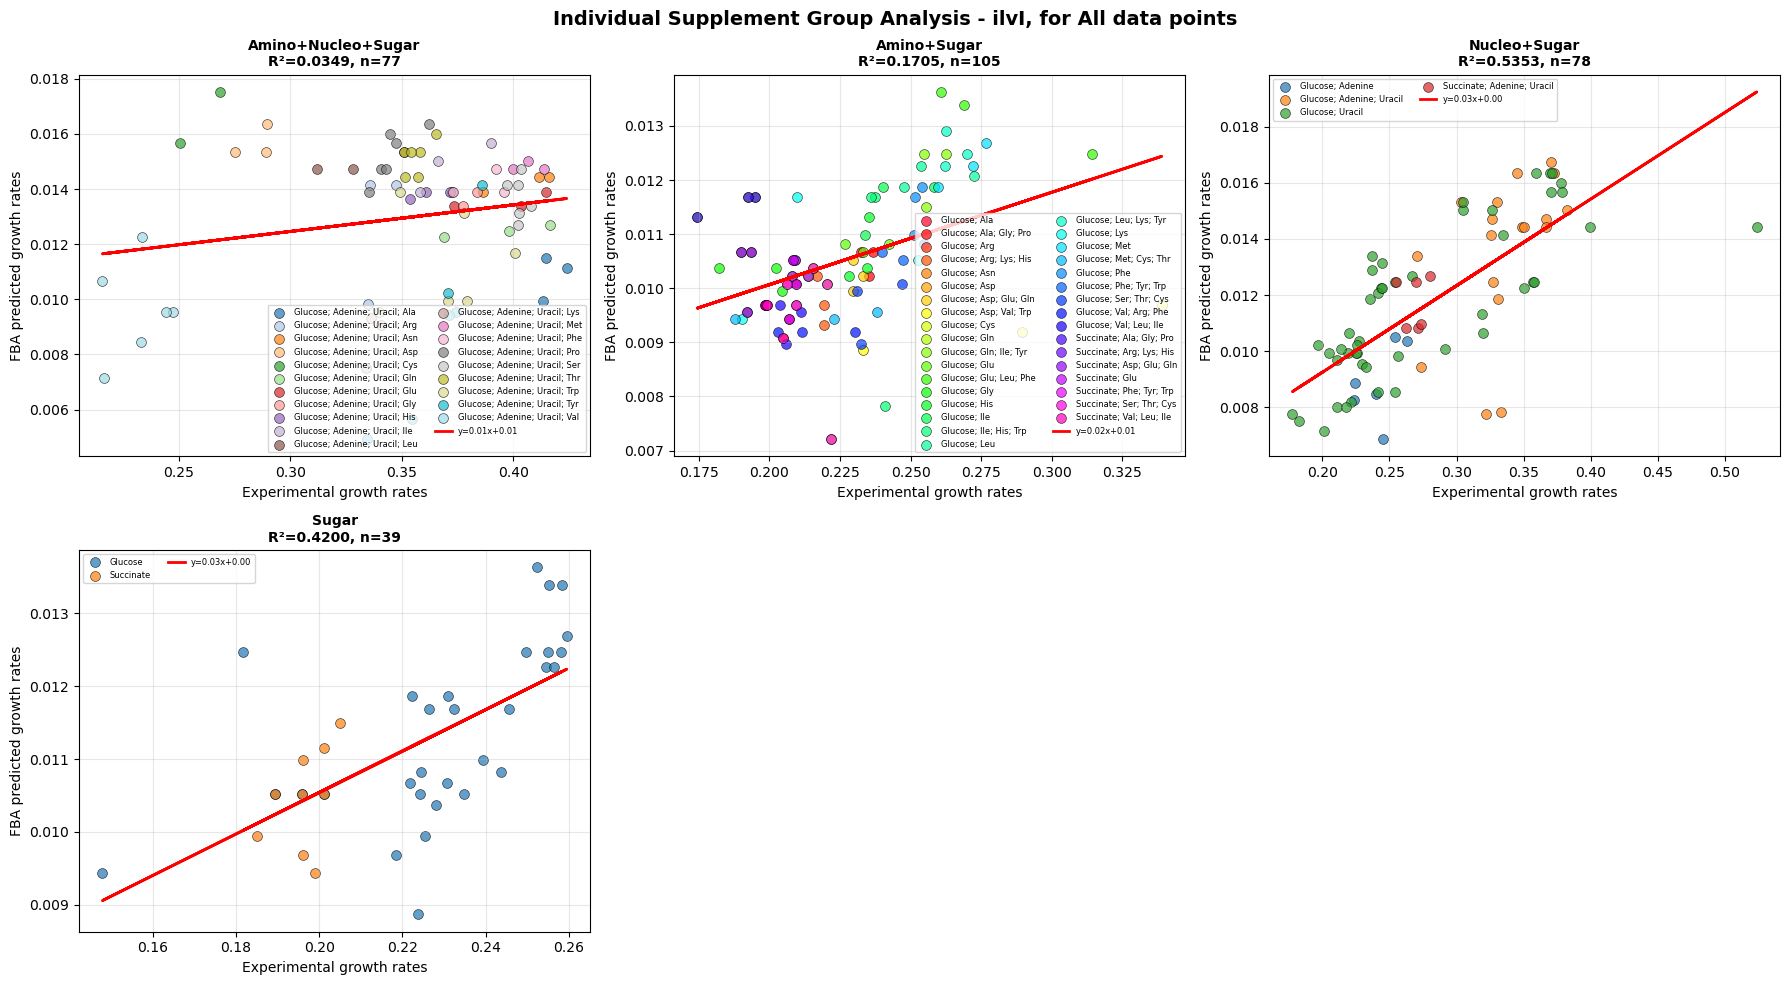

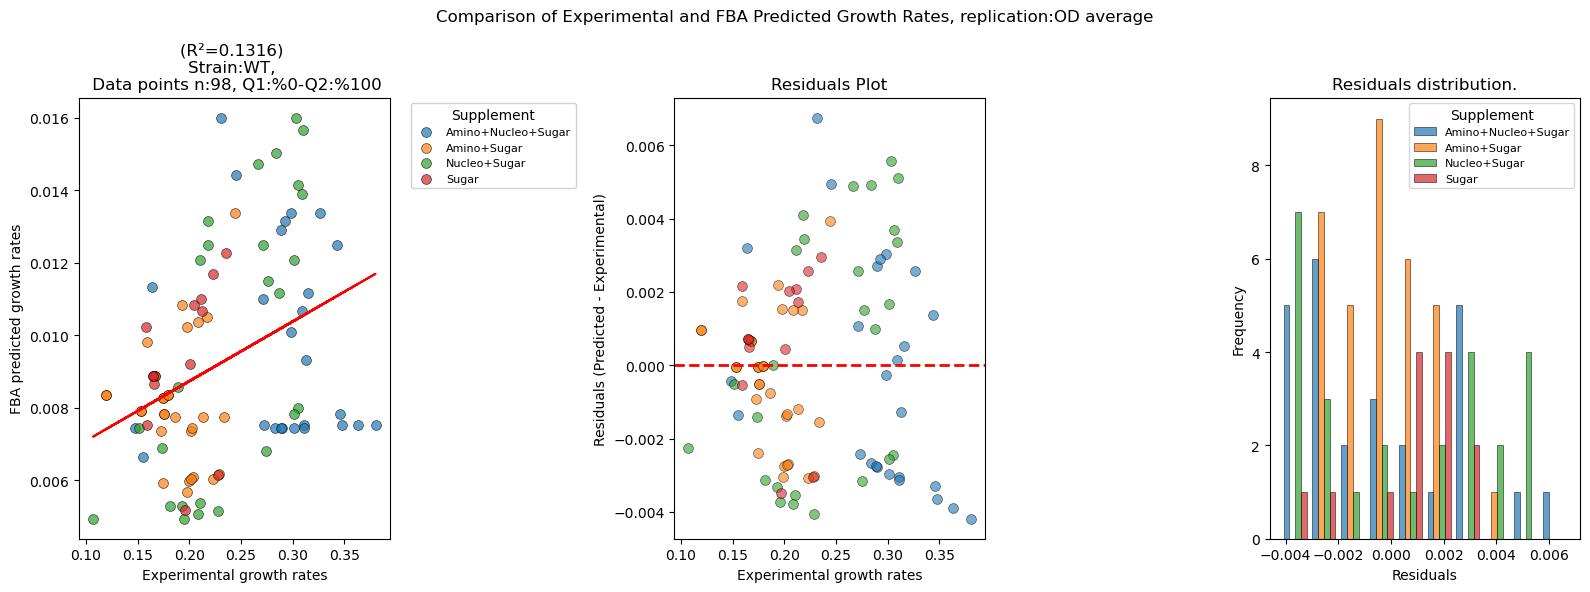

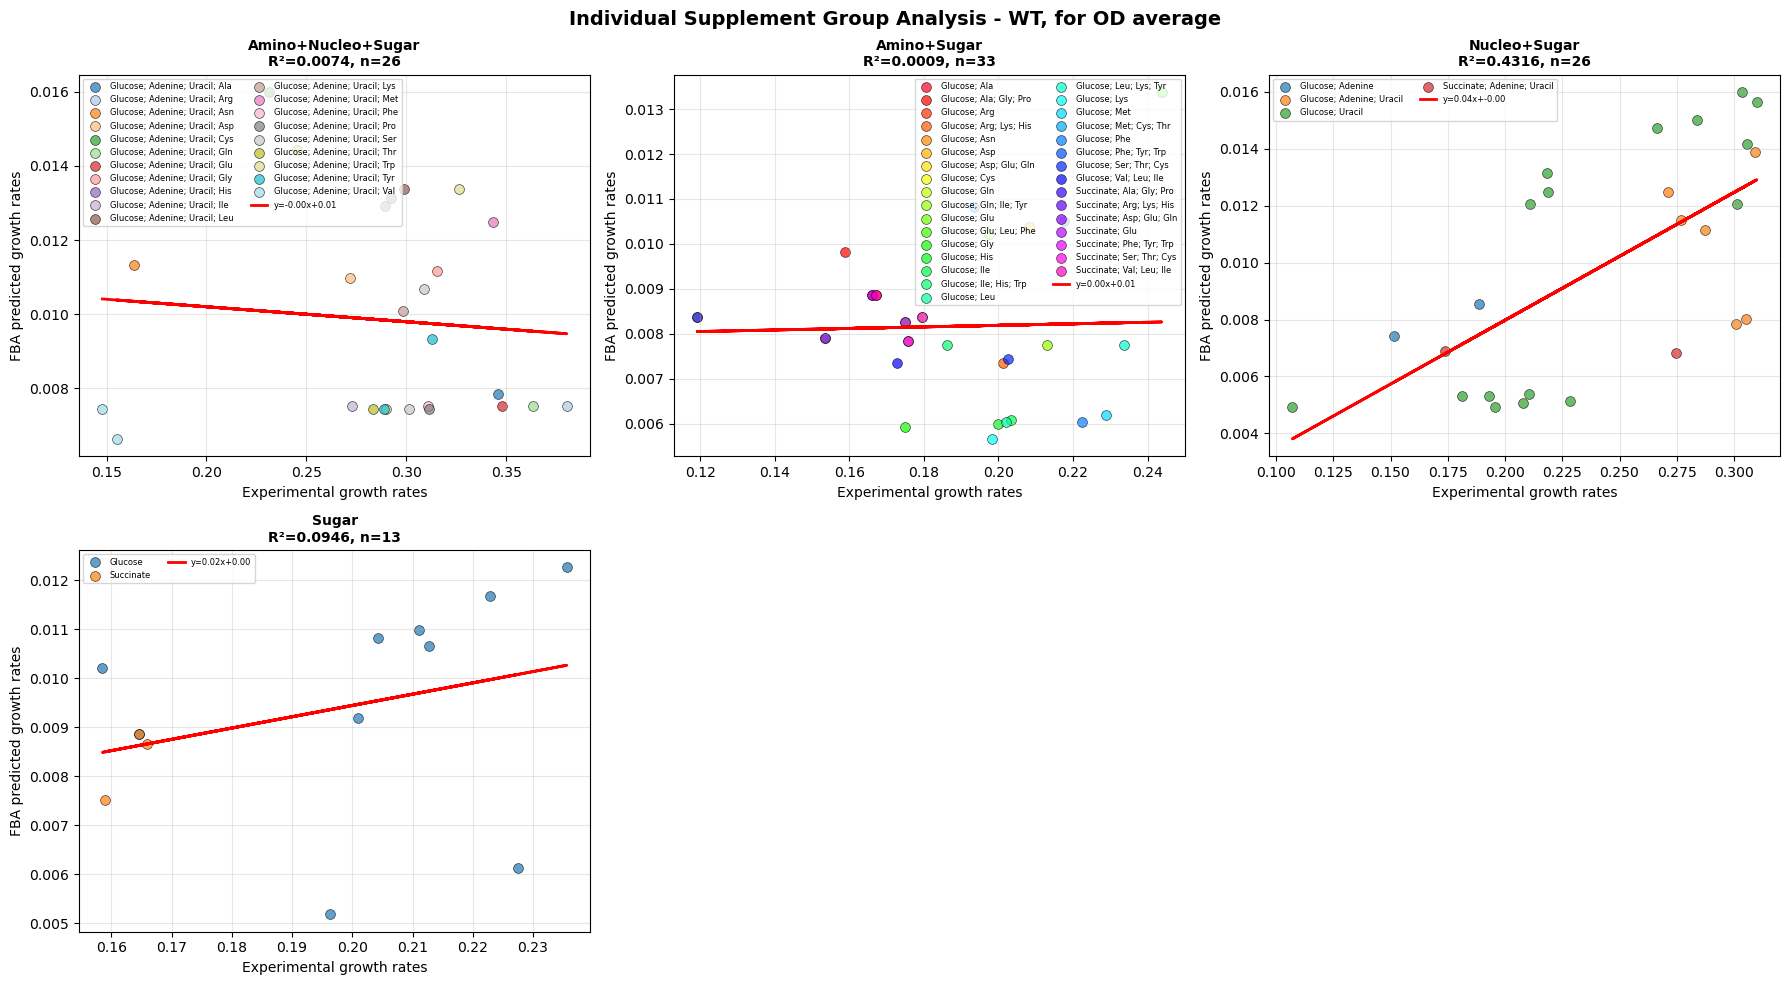

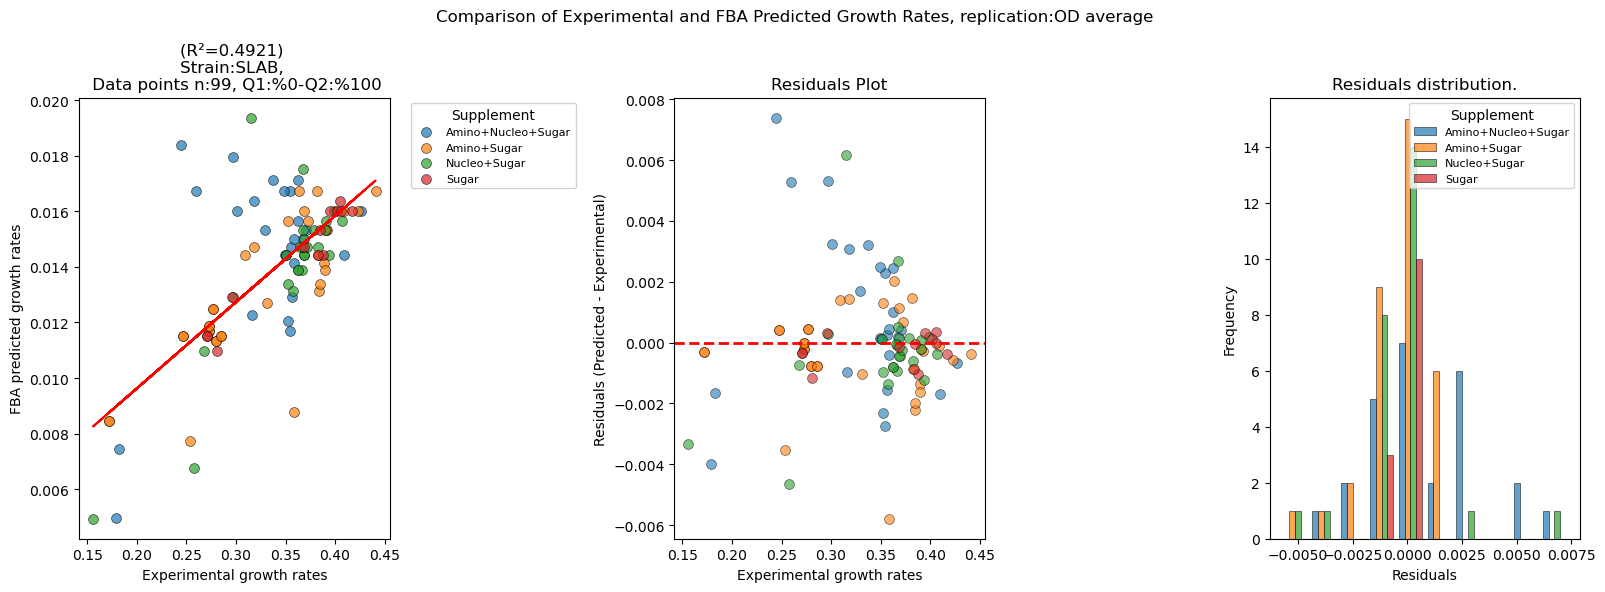

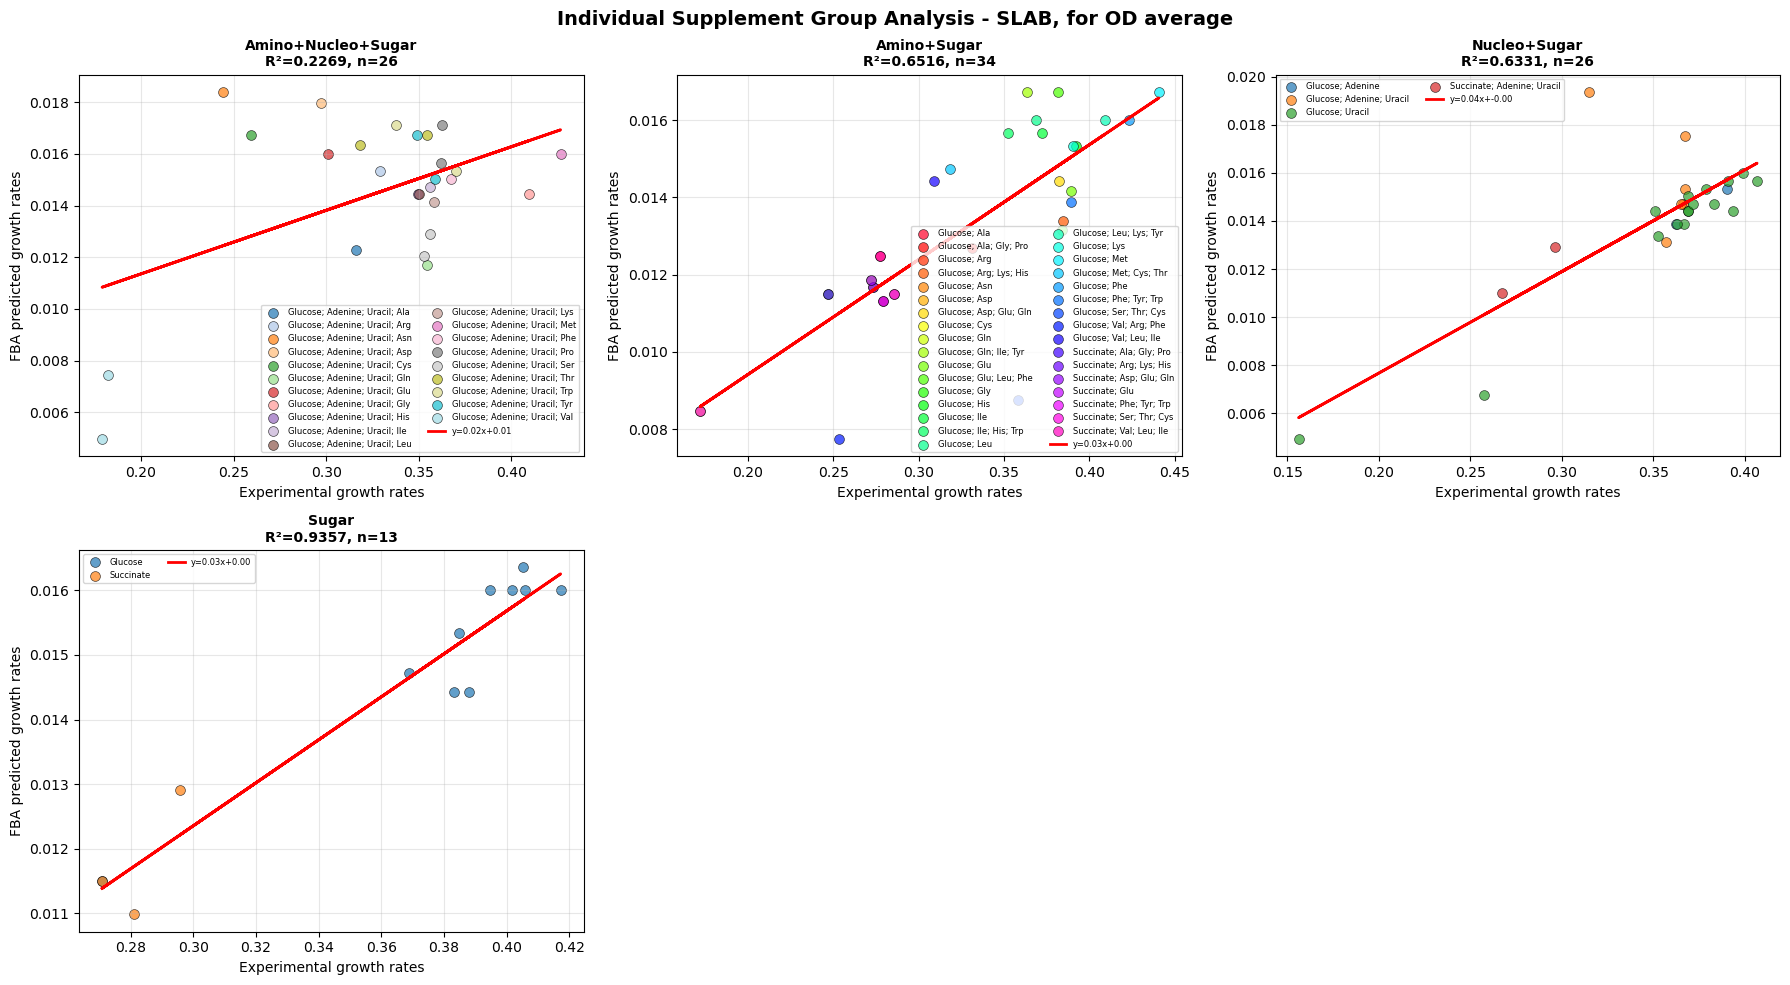

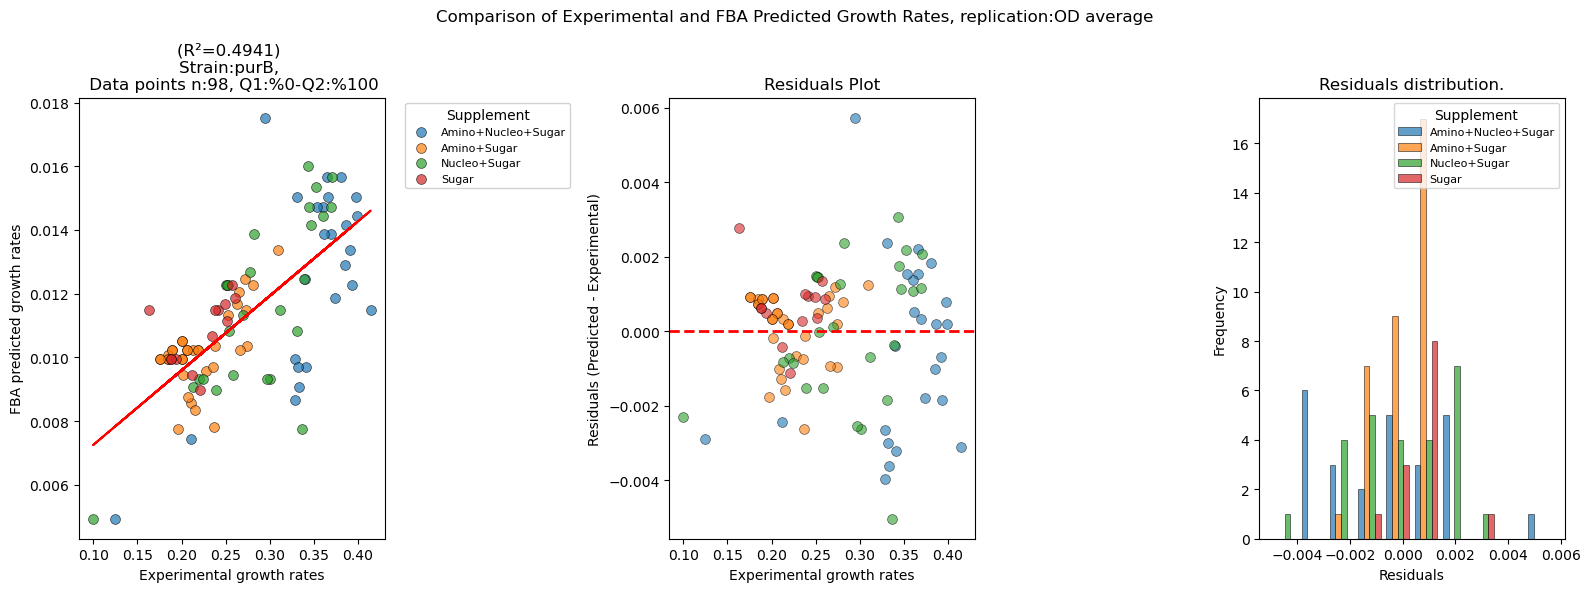

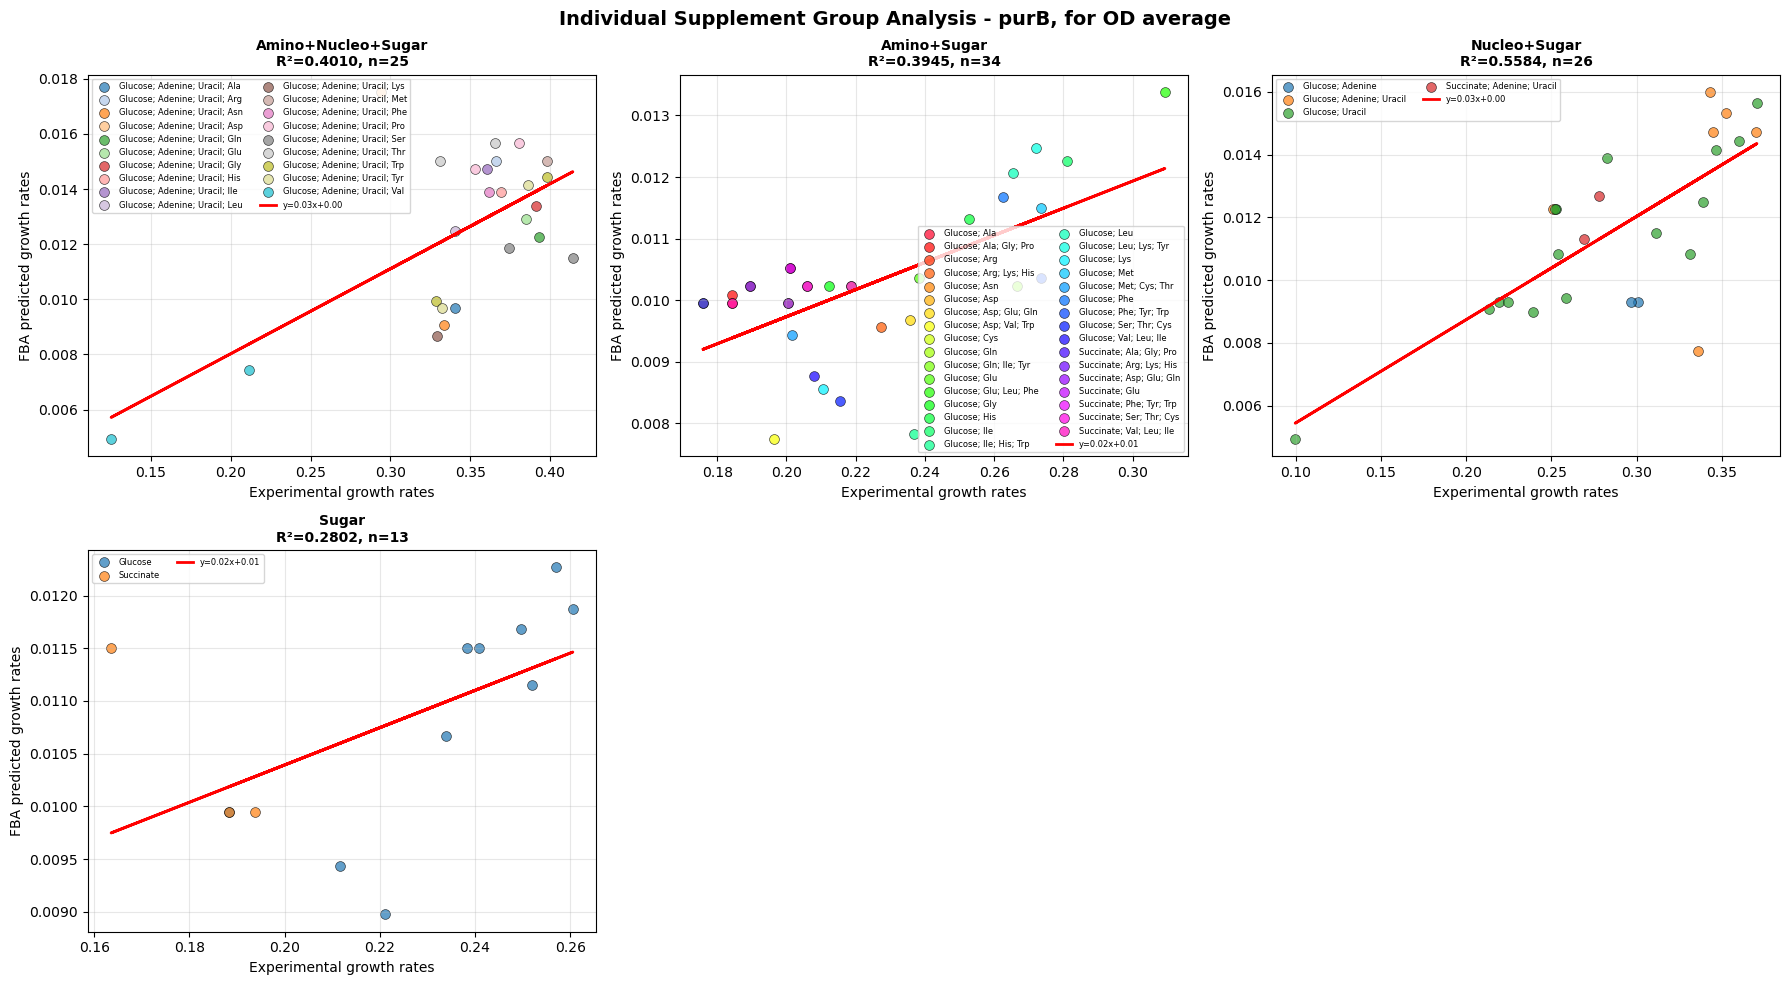

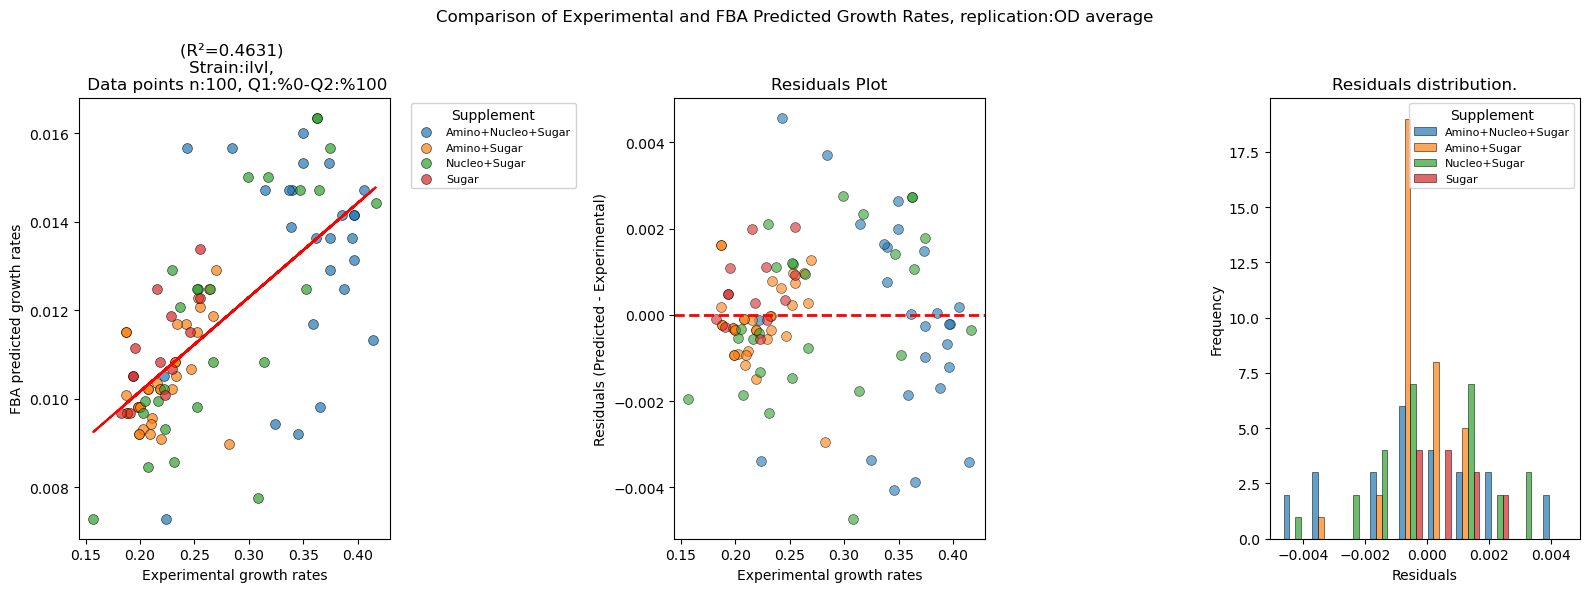

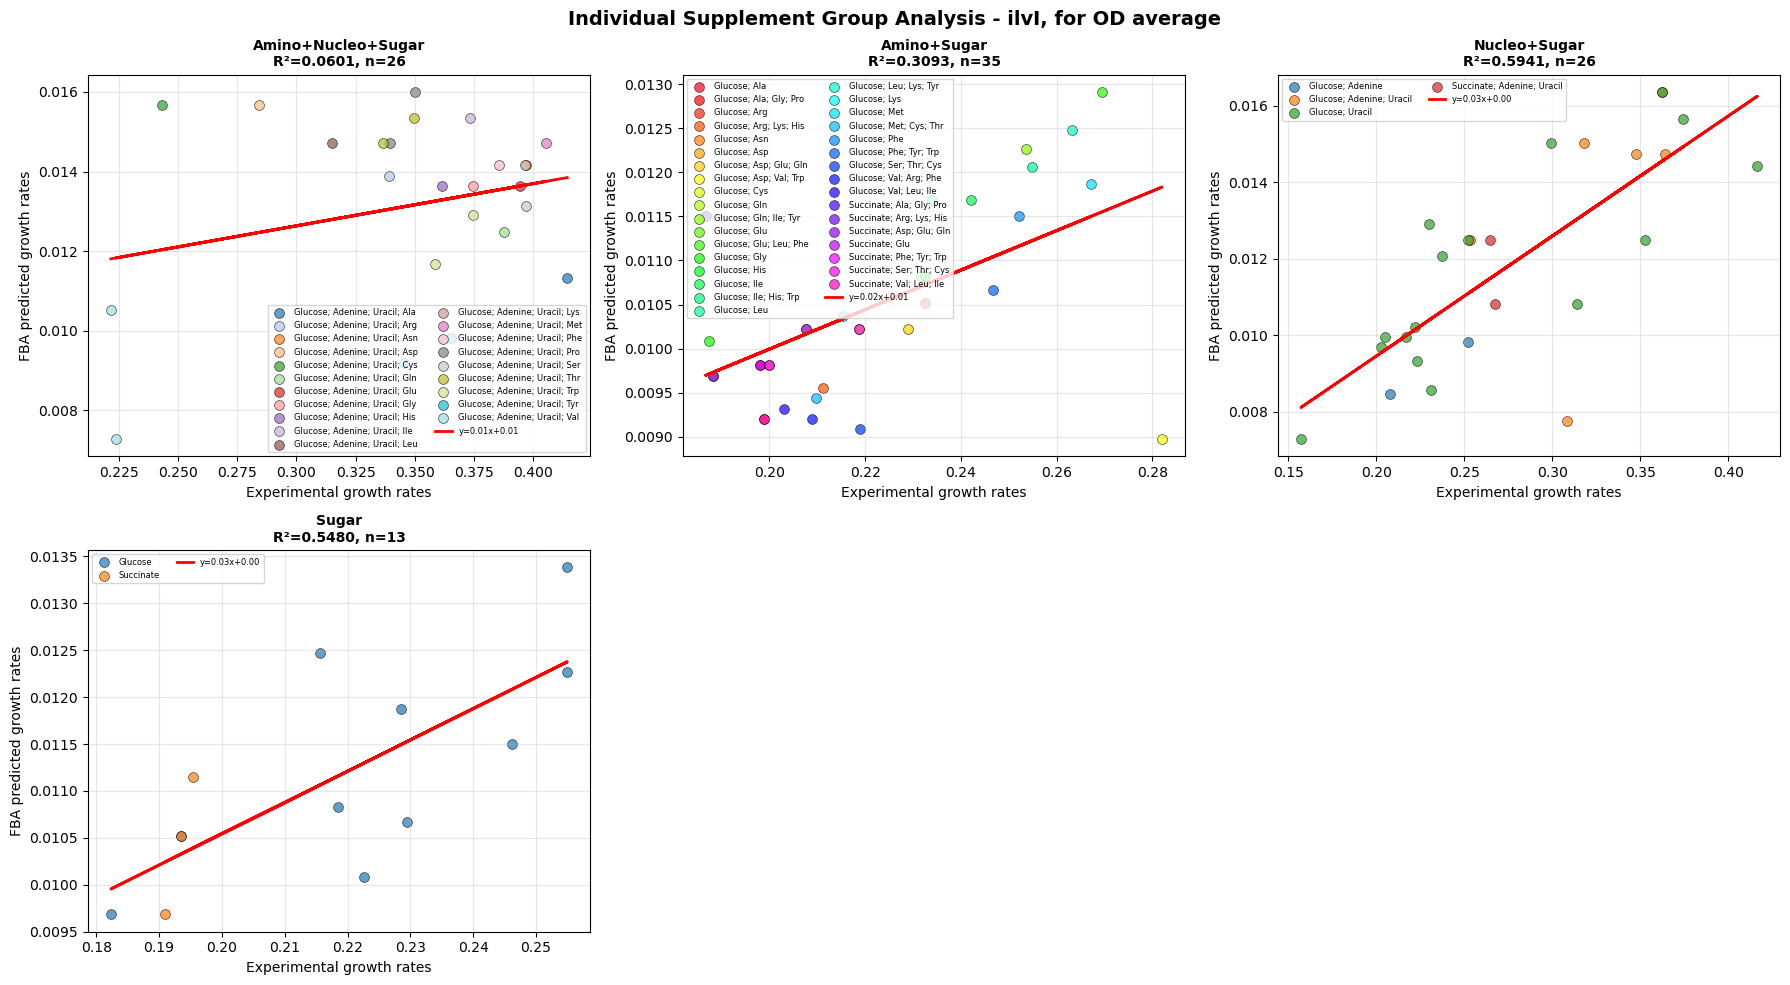

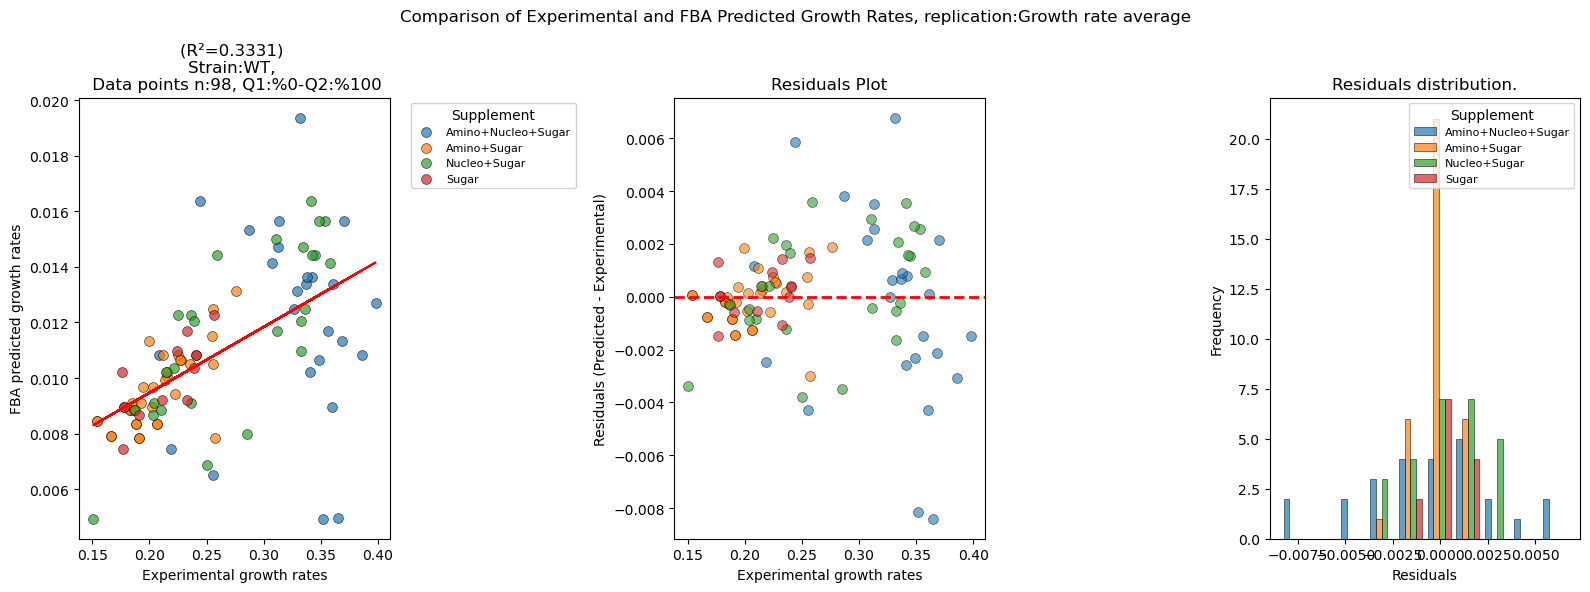

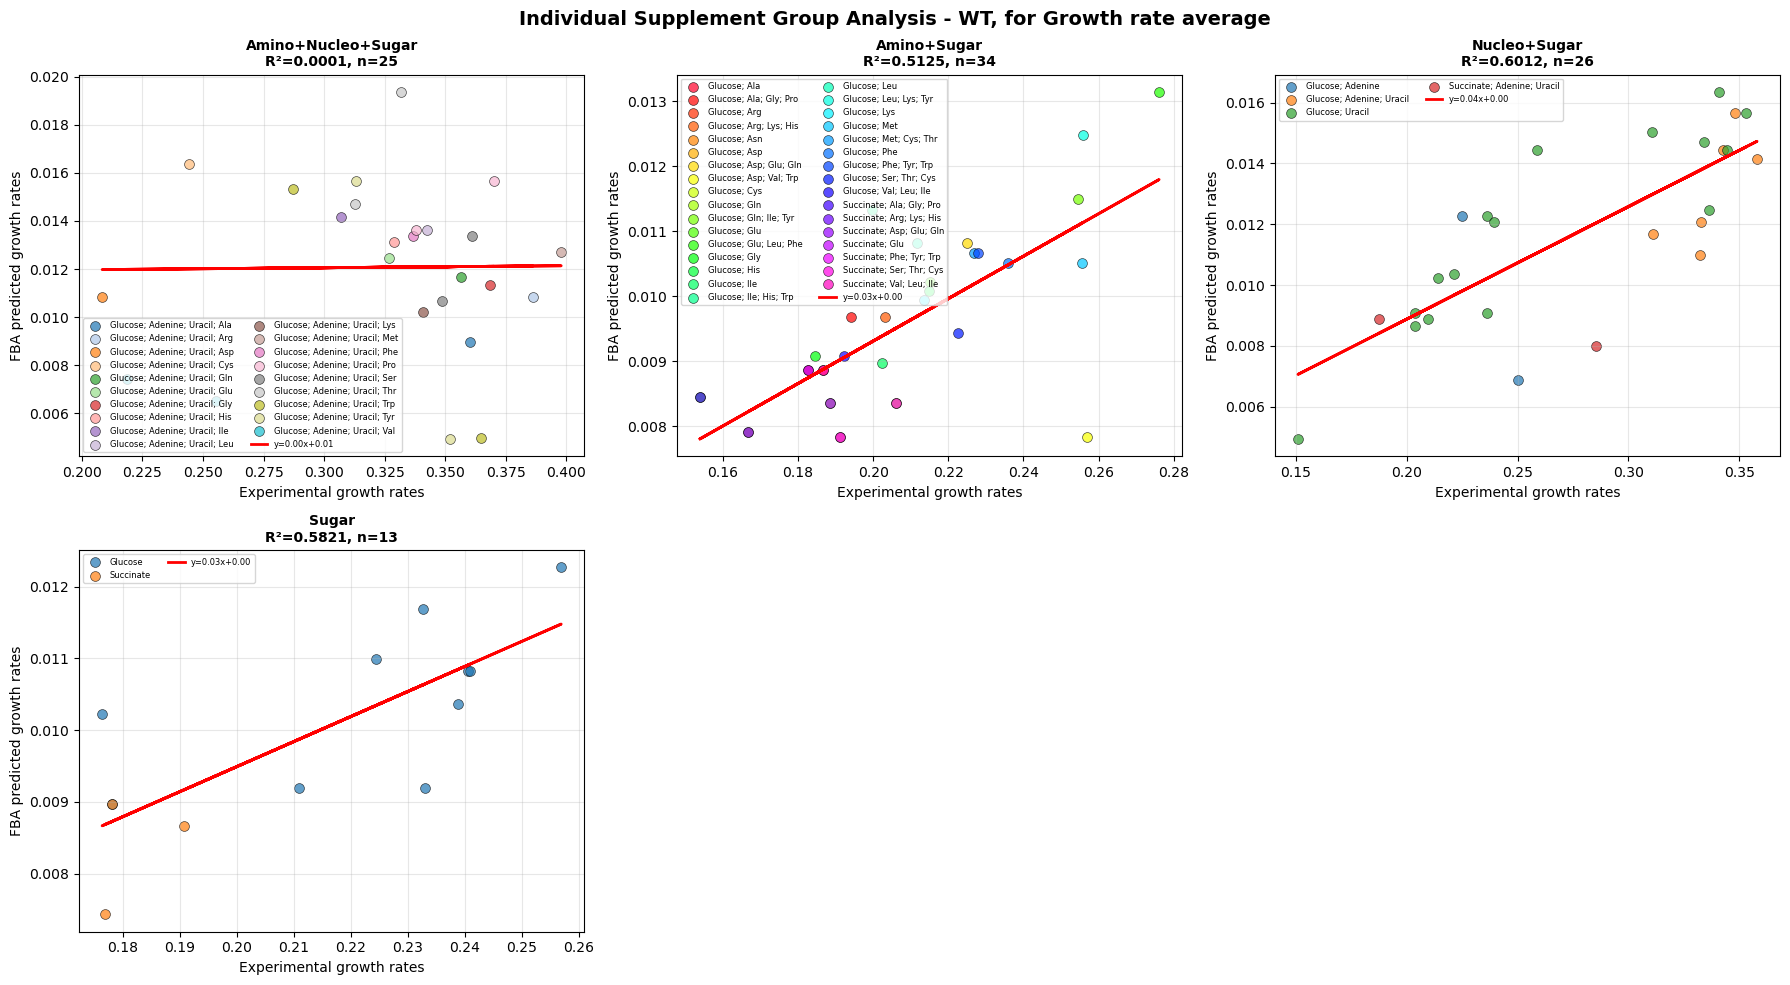

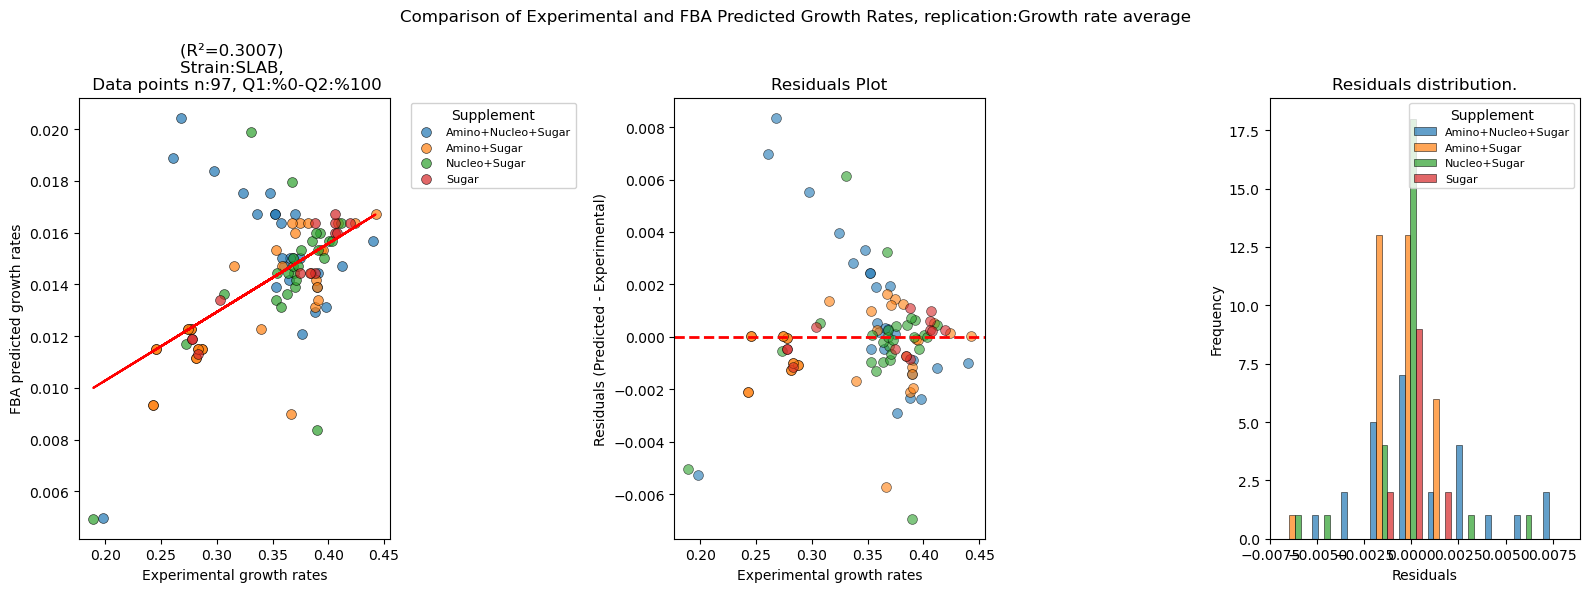

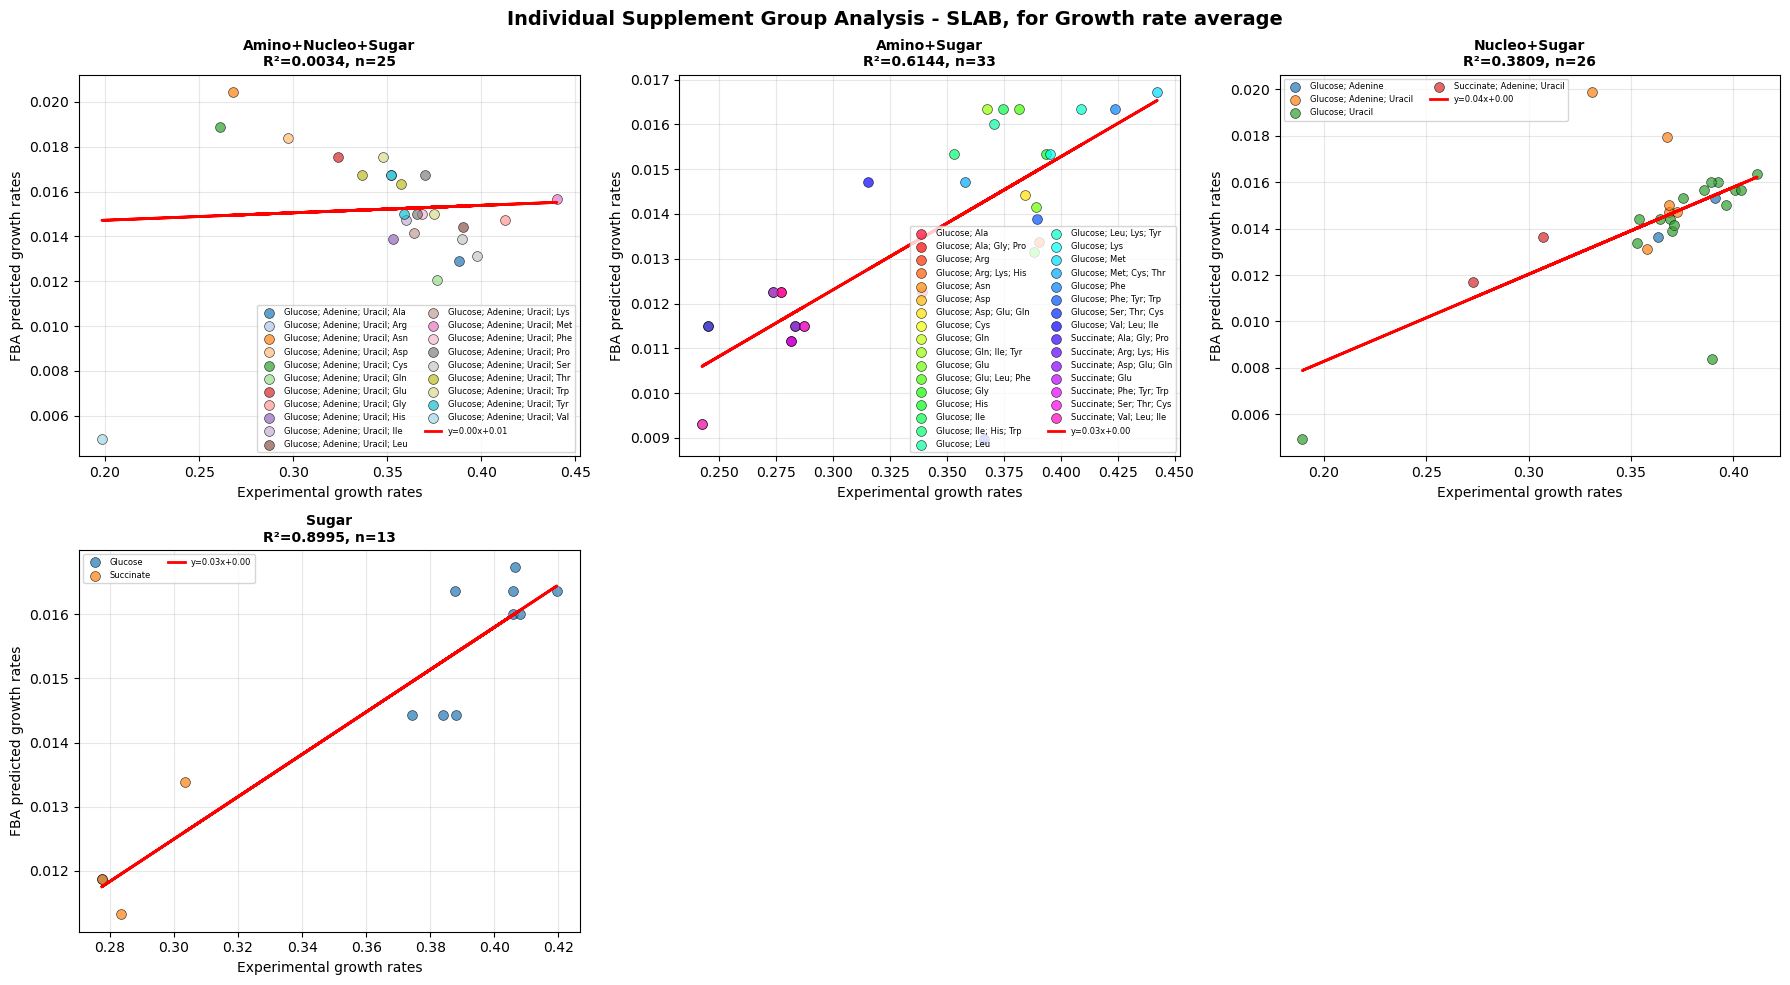

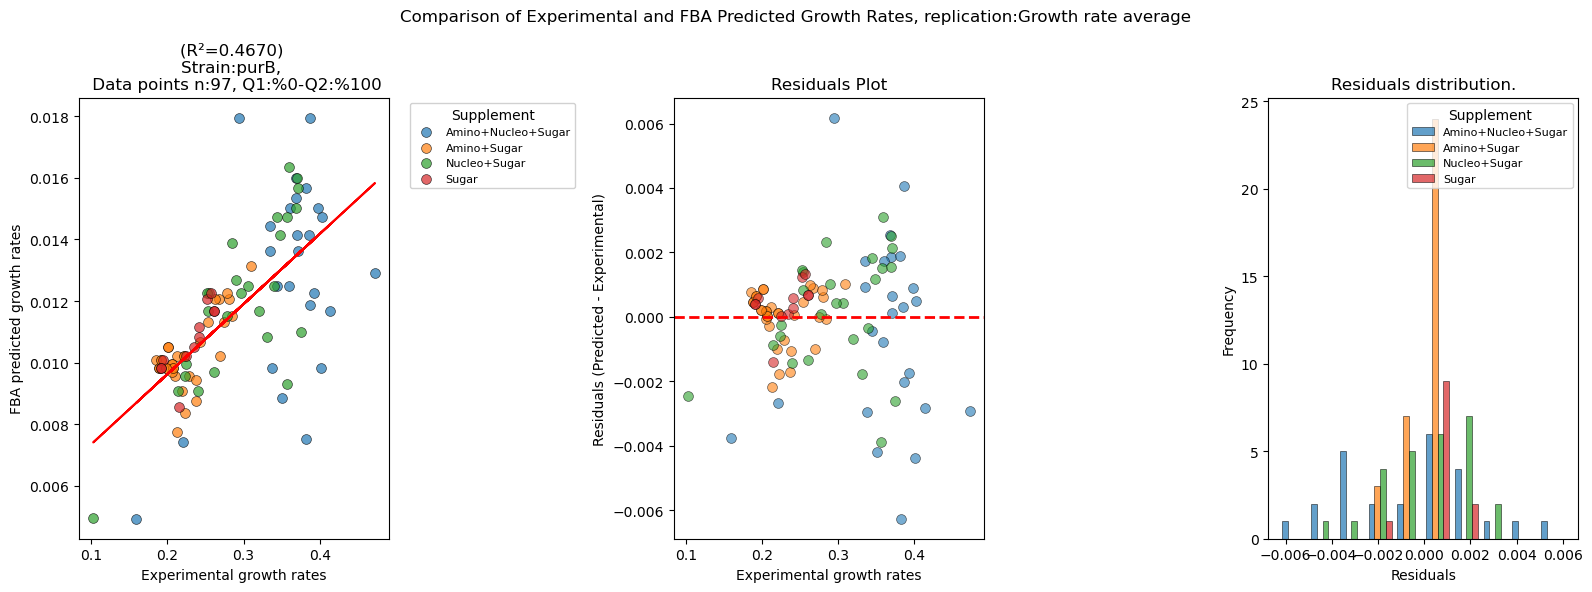

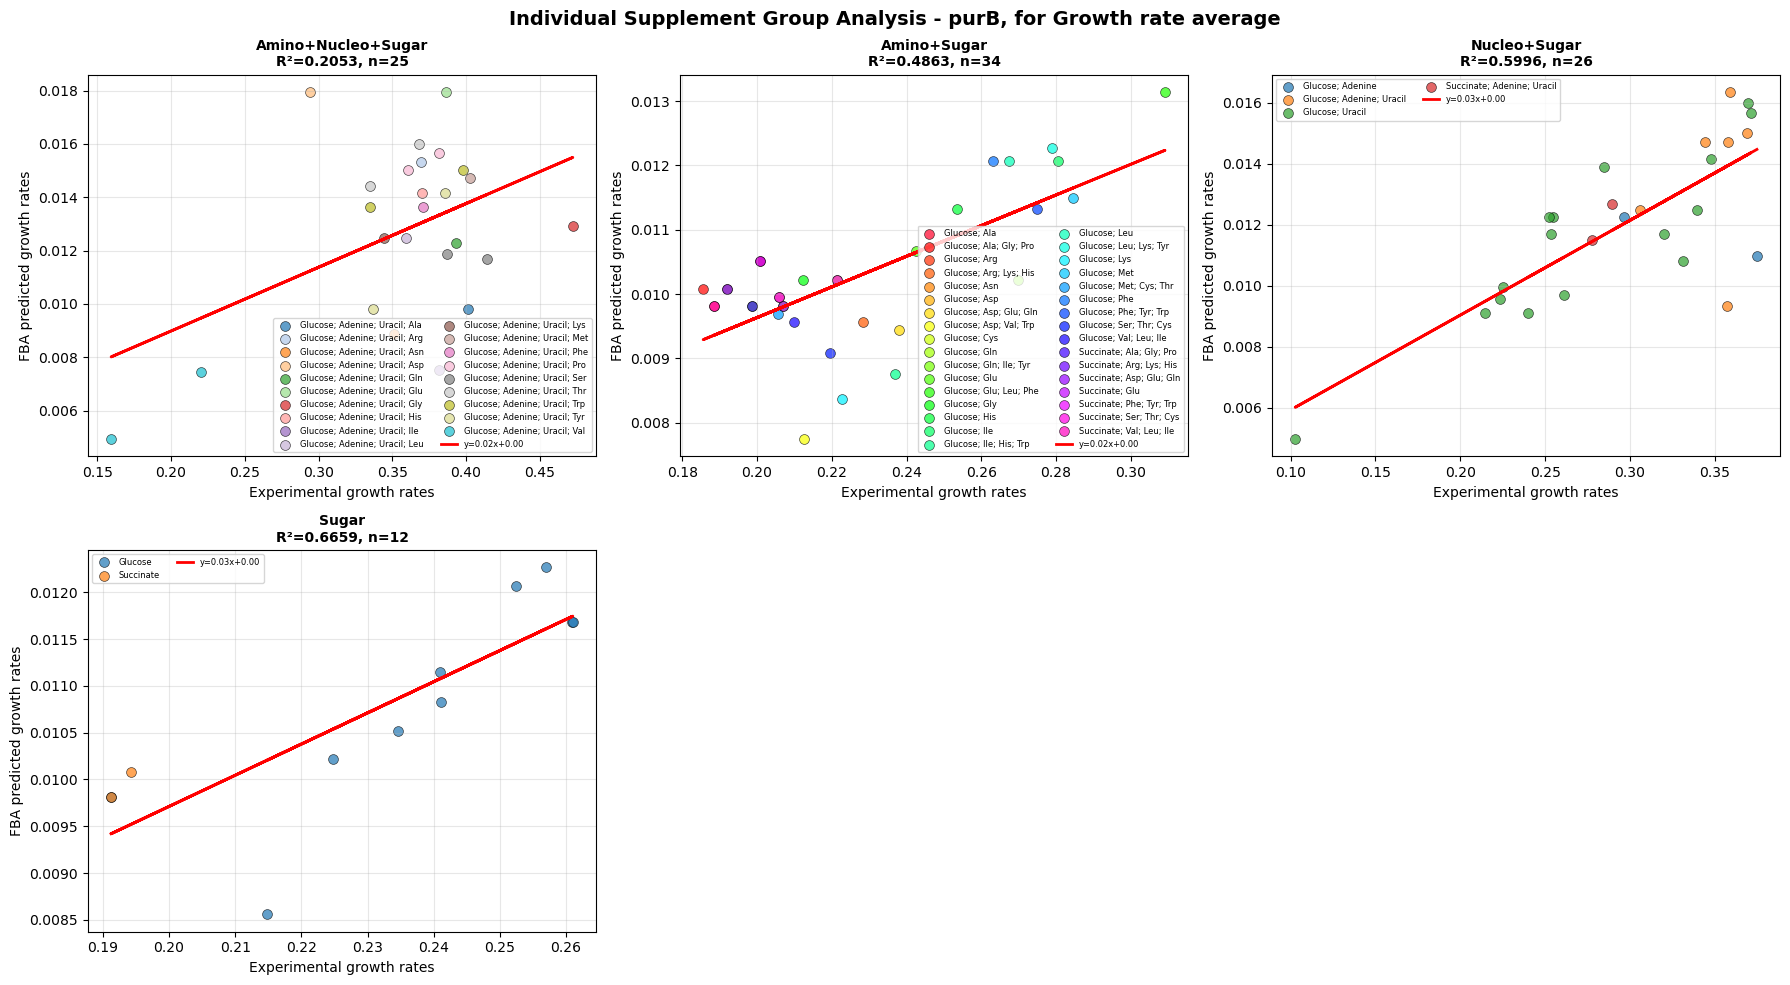

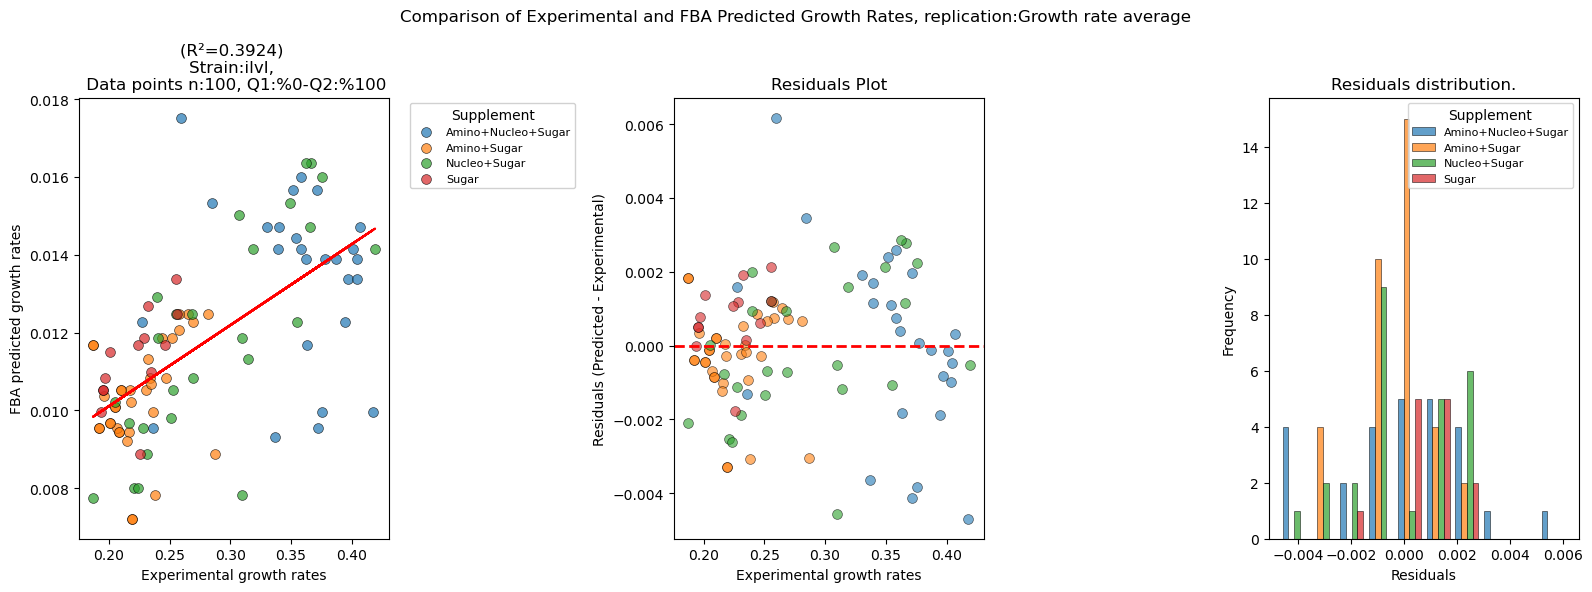

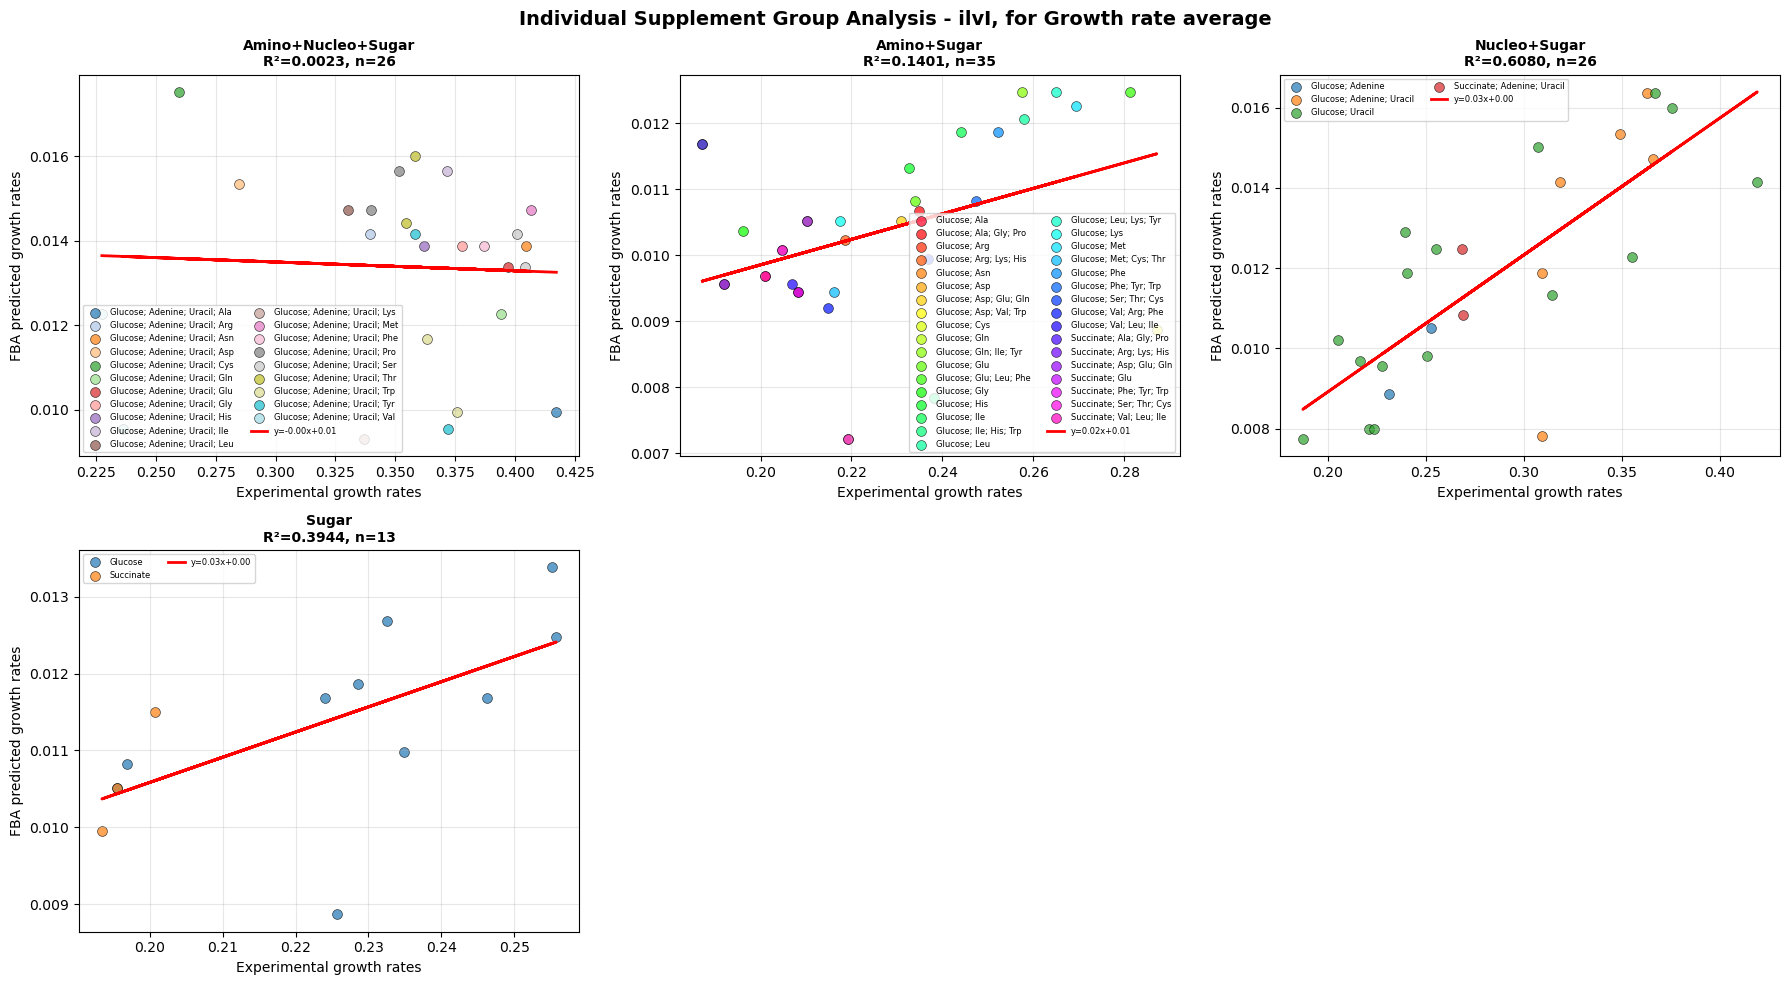

In [3]:
strains = ["WT", "SLAB", "purB", "ilvI"]
experiments = ["mediabotJLF".join(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "14"])]
replications = ["no_replicates", "replicates", "post_replicates"]
gr_columns = ["mv_mu_max", "mv_mu_max", "mv_mu_max_mean"]
for replication, gr_column in zip(replications, gr_columns):
    for strain in strains:
        run(per_strain=True,
            strain=strain,
            replication=replication,
            gr_column=gr_column)

In [4]:
import cobra
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

def run_group(per_strain: bool = True,
        strain:str = "WT",
        replication:str = "no_replicates",
        gr_column:str = "mv_mu_max",
        experiment:str = "mediabotJLF2",
        supplement_filter="glucose",
        exact_match:bool = True,
        ):
    """
    Run FBA analysis for a specific supplement group and create detailed plots.
    
    Parameters:
    -----------
    supplement_filter : str
        The supplement to filter by (e.g., 'glucose', 'uracil', etc.)
    exact_match : bool
        If True, only matches exact supplement combinations (e.g., 'glucose' won't match 'glucose; Gly')
        If False, matches any supplement containing the filter string
    """
    model = cobra.io.load_json_model("H:/ROBOT_SCIENTIST/E_coli/iML1515.json")
    
    if per_strain:
        exp_data_path = f"H:/ROBOT_SCIENTIST/E_coli/Growth_rates/2025-10-31-27/processed/{replication}_STRAINS/{strain}/AMN_dataset/"
        growth_data_path = f"H:/ROBOT_SCIENTIST/E_coli/Growth_rates/2025-10-31-27/processed/{replication}_STRAINS/{strain}/"
    else:
        exp_data_path = f"H:/ROBOT_SCIENTIST/E_coli/Growth_rates/2025-10-31-27/processed/{replication}/{experiment}/AMN_dataset/"
        growth_data_path = f"H:/ROBOT_SCIENTIST/E_coli/Growth_rates/2025-10-31-27/processed/{replication}/{experiment}/"
    # 
    exp_data = pd.read_csv(exp_data_path + "df_flux.csv") 
    growth_data = pd.read_csv(growth_data_path + "growth_rates.csv")
    
    # Filter growth_data to match the rows in exp_data 
    growth_data = growth_data.reset_index(drop=True)
    growth_data = growth_data.loc[growth_data['success'], :]
    exp_data = exp_data.reset_index(drop=True)        
    # Remove growth rate column from growth_data to avoid duplicates
    growth_data = growth_data.drop(columns=[gr_column])                
    # Now join them - they should have the same number of rows
    combinded_data = pd.concat([exp_data.reset_index(drop=True), growth_data.reset_index(drop=True)],
                                axis=1)

    def update_uracil(val):
        for part in ["_0.5", "_22.4", "_200", "_2", "_8", "_64", "_640", "0"]:
             val = val.replace(part, "")
        return val
    combinded_data["supplements_unified"] = combinded_data["supplements"].apply(lambda x: update_uracil(str(x)) if pd.notna(x) else x)
    
    def classify(val):
        """Classify supplements into Sugar, Nucleo, Amino based on content"""
        if pd.isna(val) or str(val).lower() == 'nan' or str(val).strip() == '':
            return 'None'
        
        # Split by semicolon and convert to lowercase for comparison
        parts = str(val).lower().split(';')
        parts = [p.strip() for p in parts if p.strip()]
        
        if not parts:
            return 'None'
        
        # Define categories (all lowercase)
        sugars = ['glucose', 'succinate', 'sucrose', 'galactose', 'fructose', 'mannose',
                  'maltose', 'lactose', 'xylose', 'arabinose', 'ribose']
        
        nucleobases = ['adenine', 'uracil', 'guanine', 'cytosine', 'thymine']
        
        # Amino acids are typically 3 letters (all lowercase)
        amino_acids_3letter = ['ala', 'arg', 'asn', 'asp', 'cys', 'gln', 'glu', 'gly',
                               'his', 'ile', 'leu', 'lys', 'met', 'phe', 'pro', 'ser',
                               'thr', 'trp', 'tyr', 'val']
        
        categories = []
        for part in parts:
            # Check if it's a sugar
            if any(sugar in part for sugar in sugars):
                if 'Sugar' not in categories:
                    categories.append('Sugar')
            # Check if it's a nucleobase
            elif any(nucleo in part for nucleo in nucleobases):
                if 'Nucleo' not in categories:
                    categories.append('Nucleo')
            # Check if it's a 3-letter amino acid or contains common amino acid patterns
            elif any(aa in part for aa in amino_acids_3letter) or len(part) == 3:
                if 'Amino' not in categories:
                    categories.append('Amino')
        
        if not categories:
            return 'Other'
        
        # Sort to ensure consistent ordering
        categories.sort()
        return '+'.join(categories)
    
    combinded_data["group"] = combinded_data["supplements_unified"].apply(classify)
    
    # FILTER DATA BEFORE FBA - This is the key fix!
    if exact_match:
        # Exact match: case-insensitive comparison of the entire supplement string
        supplement_mask = combinded_data['supplements_unified'].astype(str).str.lower() == supplement_filter.lower()
    else:
        # Contains match: finds any supplement containing the filter string
        supplement_mask = combinded_data['supplements_unified'].astype(str).str.lower().str.contains(supplement_filter.lower(), na=False)
    
    if not supplement_mask.any():
        match_type = "exactly matching" if exact_match else "containing"
        print(f"No data found for supplement {match_type} '{supplement_filter}'")
        return
    
    # Filter both exp_data and combinded_data
    exp_data_filtered = exp_data[supplement_mask].reset_index(drop=True)
    combinded_data_filtered = combinded_data[supplement_mask].reset_index(drop=True)
    
    match_type = "exact matches" if exact_match else "samples containing"
    print(f"Running FBA for {len(exp_data_filtered)} {match_type} '{supplement_filter}'")
    
    #===============================
    # Run FBA only on filtered data
    preds = []
    status = []
    for _, row in exp_data_filtered.iterrows():
        with model:
            # Set the medium according to the experimental data
            medium = model.medium.copy()
            for rxn_id in medium:
                medium[rxn_id] = 0.0  # Set high uptake rates for all exchange reactions
            for rxn_id in exp_data_filtered.columns:
                if rxn_id != gr_column:
                    medium[rxn_id] = row.get(rxn_id, 0.0)  # Set uptake rates based on experimental data
            model.medium = medium
            # Perform FBA
            model.objective = 'BIOMASS_Ec_iML1515_core_75p37M'                
            solution = model.optimize()        
            preds.append(solution.objective_value)
            status.append(solution.status  == 'optimal')
    
    # Remove outliers from predictions
    preds_array = np.array(preds)
    status_array = np.array(status)
    percentile_lower = 0
    percentile_upper = 100
    q1 = np.percentile(preds_array, percentile_lower)
    q3 = np.percentile(preds_array, percentile_upper)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    filtered_preds = [pred if lower_bound <= pred <= upper_bound else np.nan for pred in preds_array]
    filtered_status = [status_array[i] if lower_bound <= preds_array[i] <= upper_bound else False for i in range(len(preds_array))]
    
    masks = [s for s in filtered_status]
    
    # Get filtered data for plotting
    y = np.array([p for p, m in zip(filtered_preds, masks) if m])
    x = np.array(combinded_data_filtered[gr_column][masks])
    
    # Get individual supplements for color coding
    supplements = combinded_data_filtered['supplements_unified'][masks].values
    unique_supps = np.unique(supplements)
    n_supps = len(unique_supps)
    
    # Create color map - same logic as in run()
    if n_supps <= 10:
        colors = plt.cm.tab10(np.linspace(0, 1, 10))[:n_supps]
    elif n_supps <= 20:
        colors = plt.cm.tab20(np.linspace(0, 1, 20))[:n_supps]
    else:
        colors = plt.cm.gist_rainbow(np.linspace(0, 1, n_supps))
    
    supp_colors = {supp: colors[i] for i, supp in enumerate(unique_supps)}
    
    # Create figure with 3 subplots
    fig = plt.figure(figsize=(16, 6))
    ax1, ax2, ax3 = fig.subplots(1, 3)
    
    # Plot each supplement with its own color
    for supp in unique_supps:
        supp_mask = supplements == supp
        ax1.scatter(x[supp_mask], y[supp_mask], 
                   color=supp_colors[supp], 
                   label=supp, 
                   alpha=0.7, 
                   s=50,
                   edgecolors='black',
                   linewidths=0.5)
    
    # Regression line
    m, b = np.polyfit(x, y, 1)
    ax1.plot(x, m*x + b, color='red', linewidth=2, label=f'y={m:.2f}x+{b:.2f}')
    
    # Calculate R²
    correlation_matrix = np.corrcoef(x, y)
    correlation_xy = correlation_matrix[0, 1]
    r_squared = correlation_xy**2
    
    ax1.set_xlabel("Experimental growth rates")
    ax1.set_ylabel("FBA predicted growth rates")
    if per_strain:
        subtitle = f"Strain:{strain}, Supplement:{supplement_filter}\nData points n:{len(x)}"
    else:
        subtitle = f"Experiment:{experiment}, Supplement:{supplement_filter}\nData points n:{len(x)}"
    ax1.set_title(f"(R²={r_squared:.4f})\n{subtitle}")
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, 
              title='Supplement', framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    
    #==========================
    # Residuals plot
    residuals = y - (m * x + b)
    for supp in unique_supps:
        supp_mask = supplements == supp
        ax2.scatter(x[supp_mask], residuals[supp_mask], 
                   color=supp_colors[supp], 
                   alpha=0.7,
                   s=50,
                   edgecolors='black',
                   linewidths=0.5)
    ax2.axhline(0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel("Experimental growth rates")
    ax2.set_ylabel("Residuals (Predicted - Experimental)")
    ax2.set_title("Residuals Plot")
    ax2.grid(True, alpha=0.3)
    
    #==========================
    # Residual distribution histogram
    ax3.hist([residuals[supplements == supp] for supp in unique_supps],
             label=[str(supp) for supp in unique_supps],
             color=[supp_colors[supp] for supp in unique_supps],
             alpha=0.7,
             edgecolor='black',
             linewidth=0.5,
             stacked=False)
    ax3.legend(fontsize=8, title='Supplement')
    ax3.set_xlabel("Residuals")
    ax3.set_ylabel("Frequency")
    ax3.set_title("Residuals Distribution")
    
    #==========================
    match_type_label = "Exact Match" if exact_match else "Contains"
    average_type = "All data points" if replication == "no_replicates" else "OD average" if replication == "replicates" else "Growth rate average"
    plt.suptitle(f"FBA Analysis for '{supplement_filter}' ({match_type_label}) - {average_type}", 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


Running FBA for 20 exact matches 'glucose'


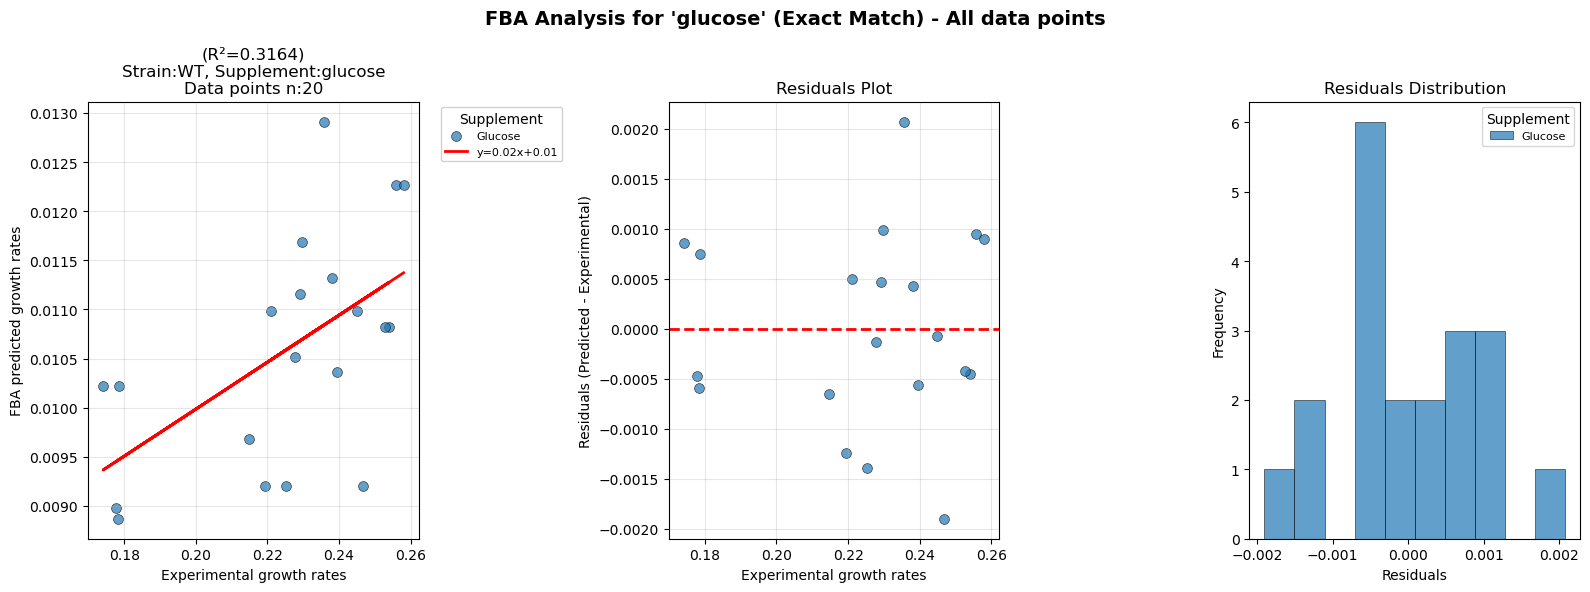

Running FBA for 6 exact matches 'succinate'


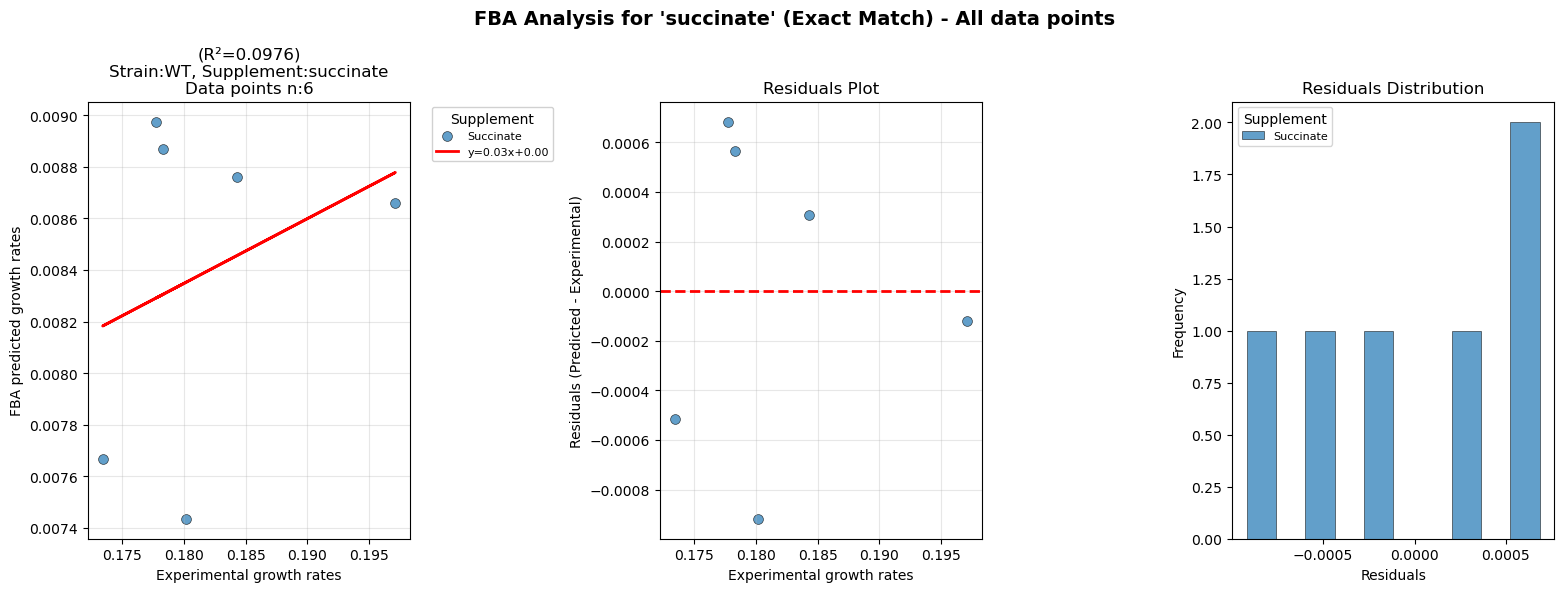

Running FBA for 30 exact matches 'glucose'


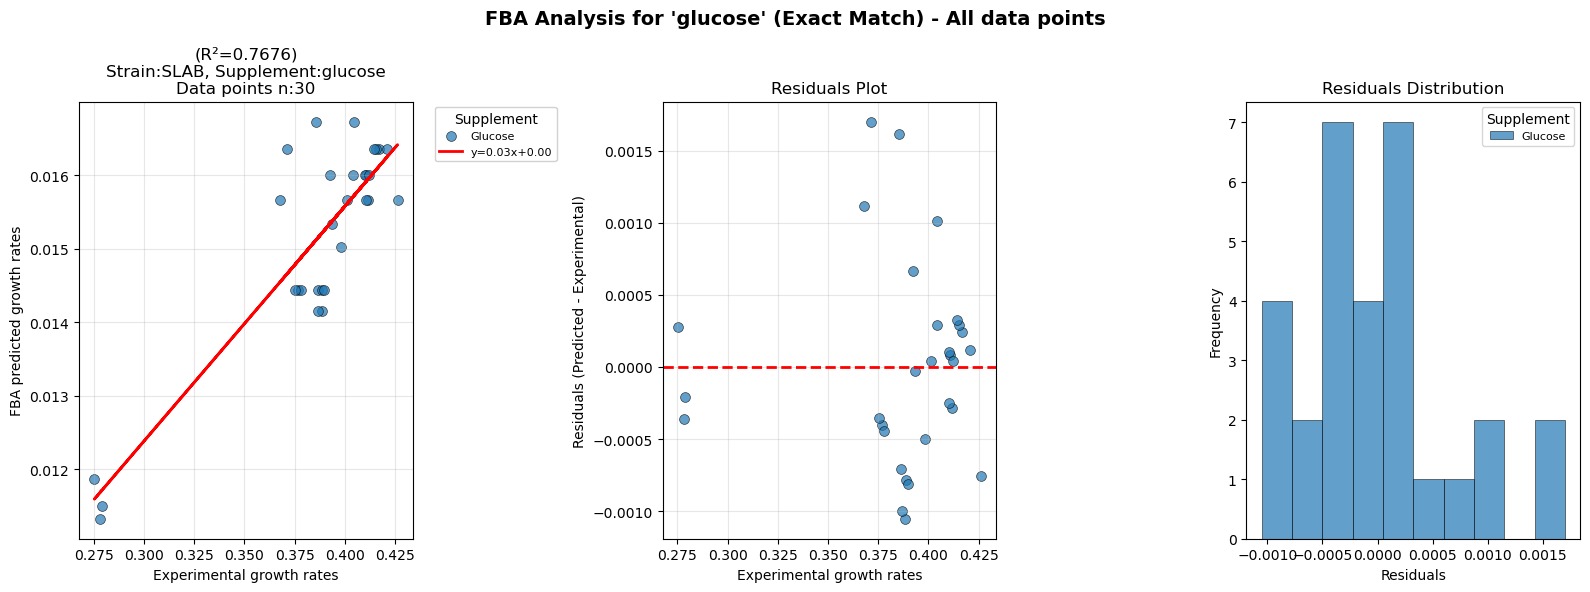

Running FBA for 9 exact matches 'succinate'


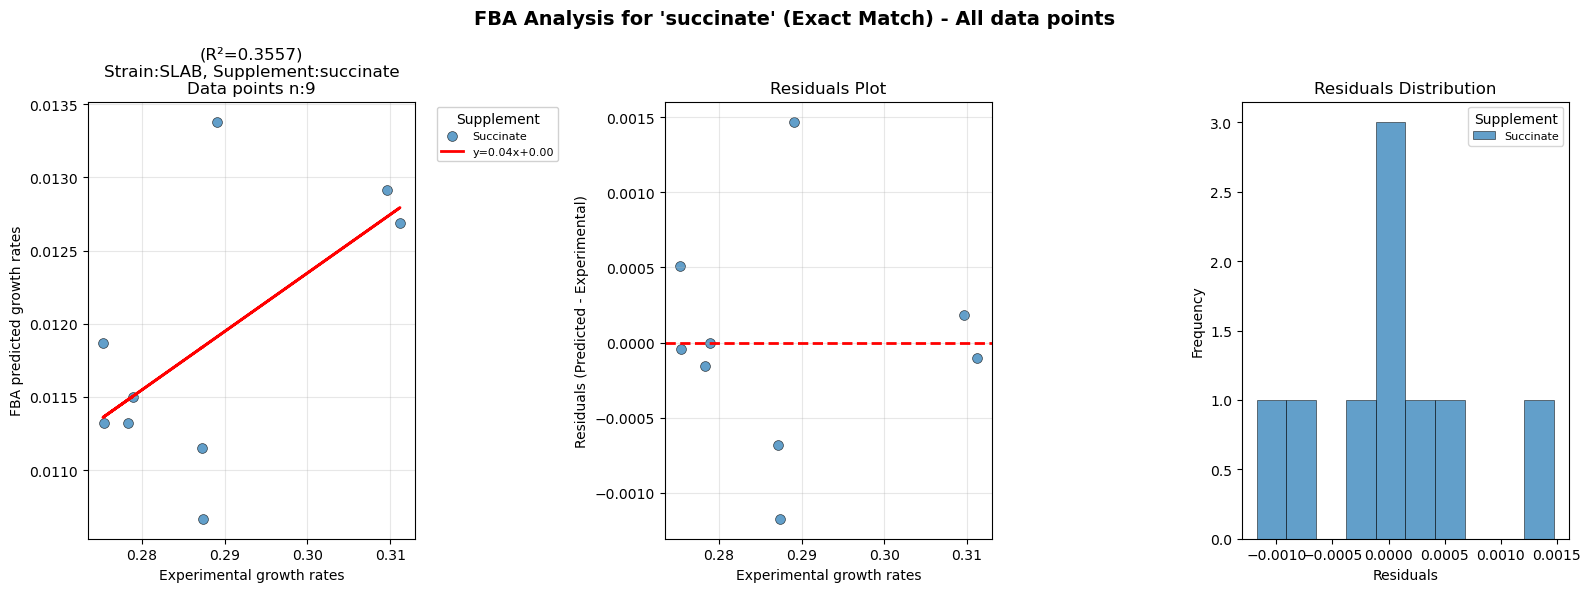

Running FBA for 30 exact matches 'glucose'


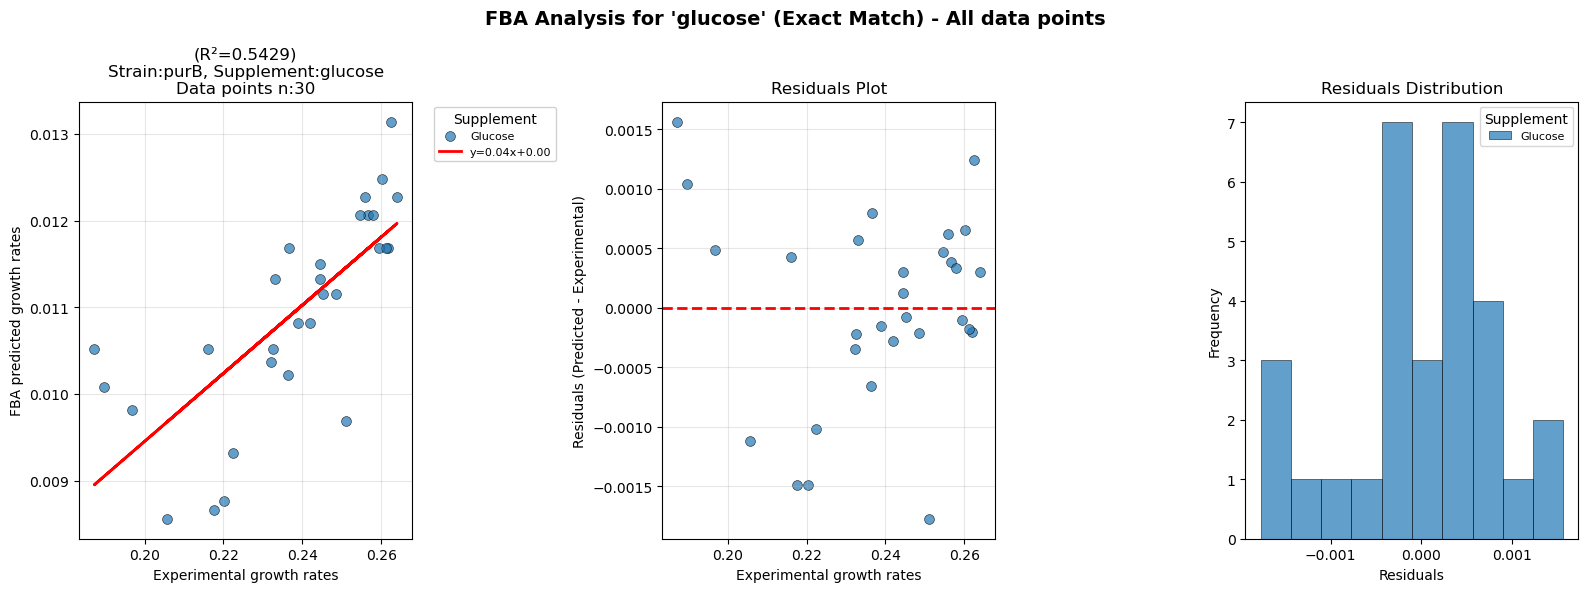

Running FBA for 8 exact matches 'succinate'


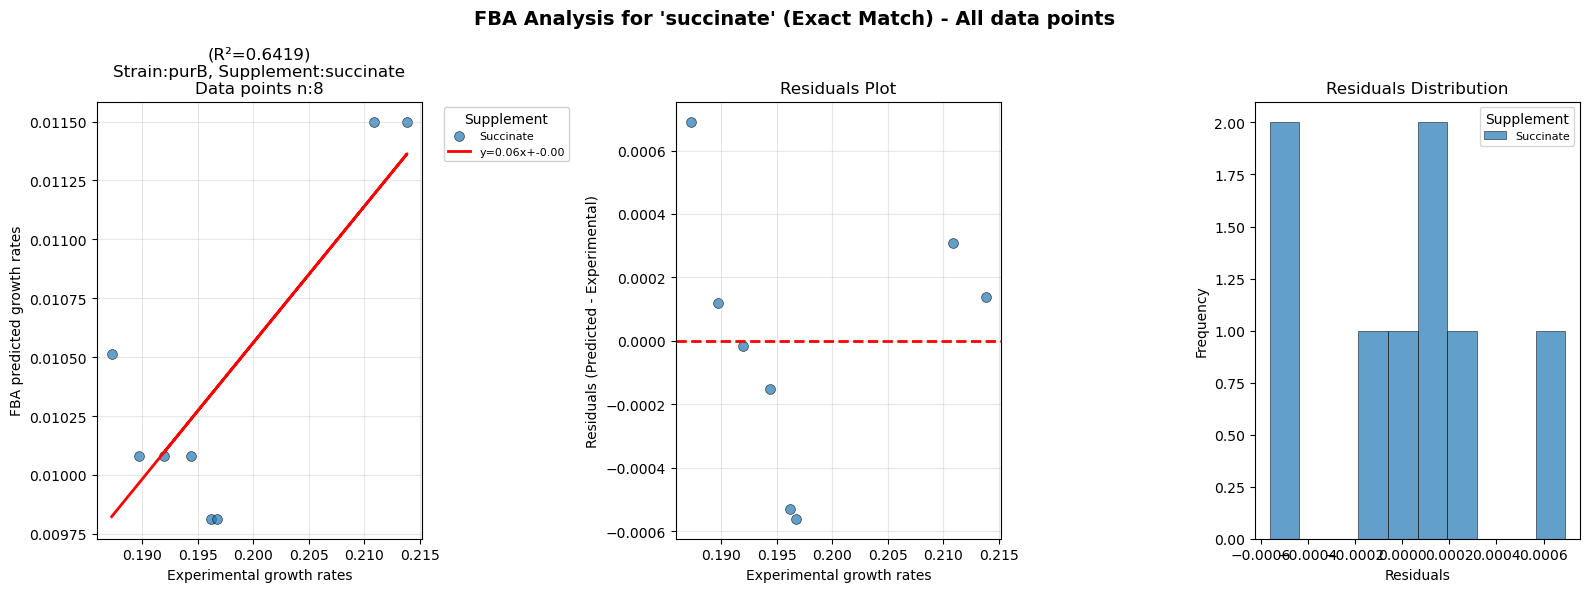

Running FBA for 30 exact matches 'glucose'


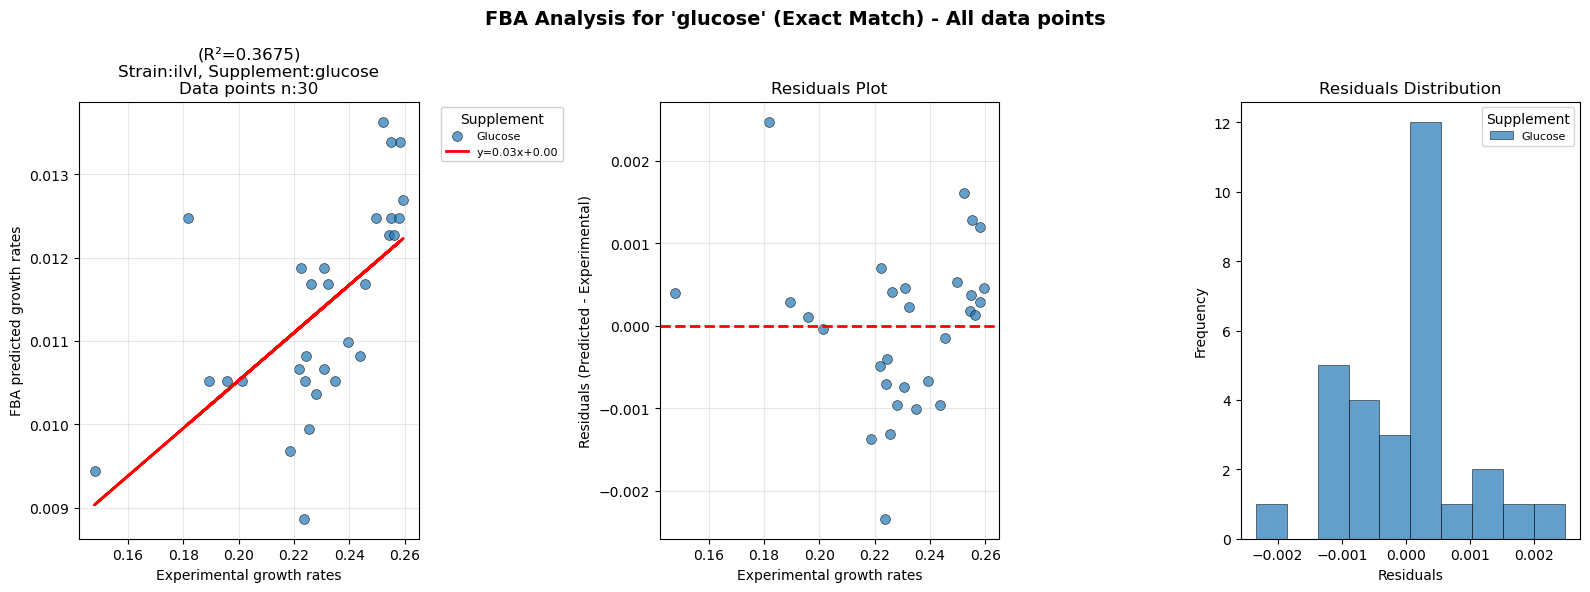

Running FBA for 9 exact matches 'succinate'


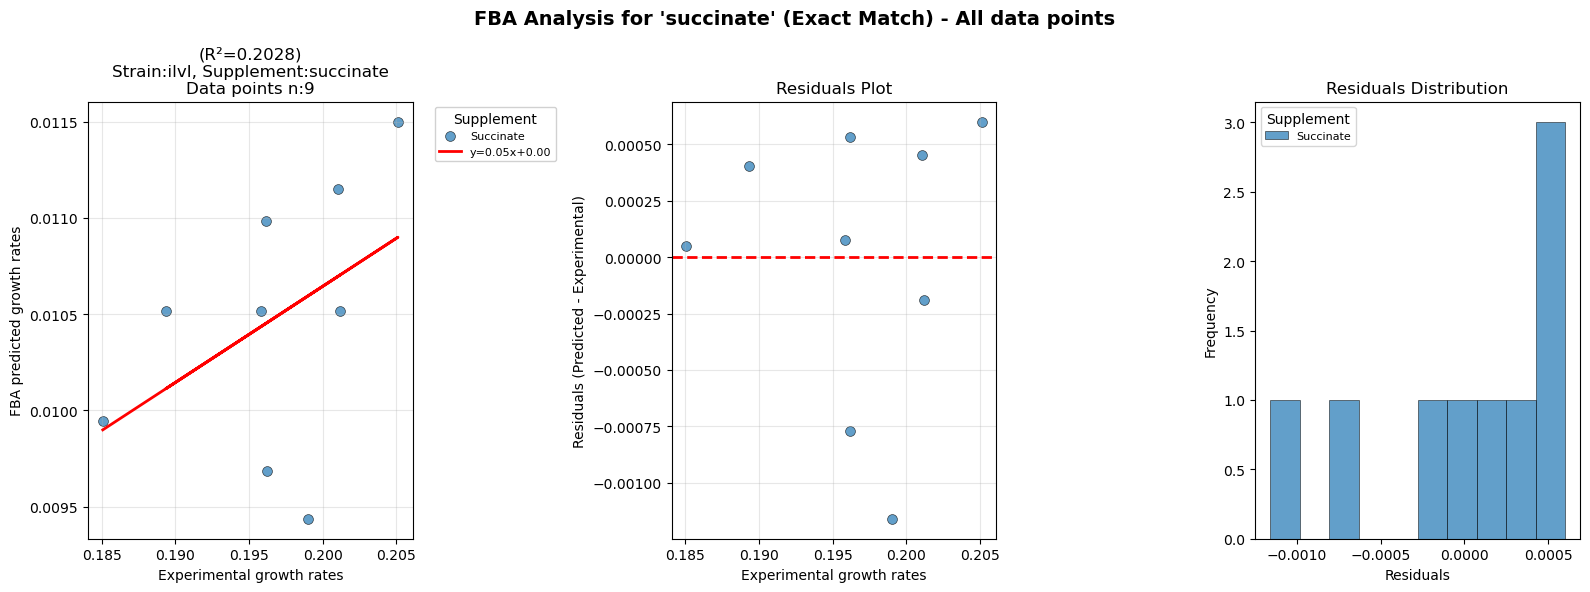

Running FBA for 10 exact matches 'glucose'


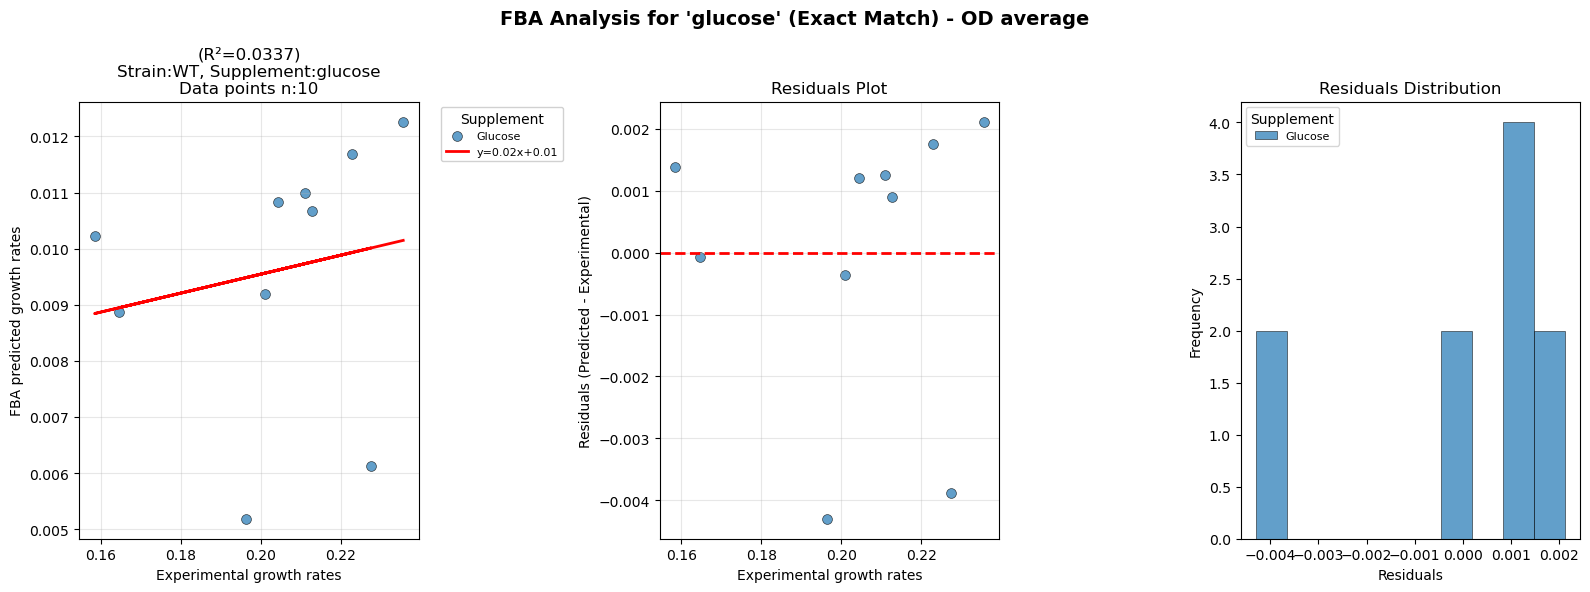

Running FBA for 3 exact matches 'succinate'


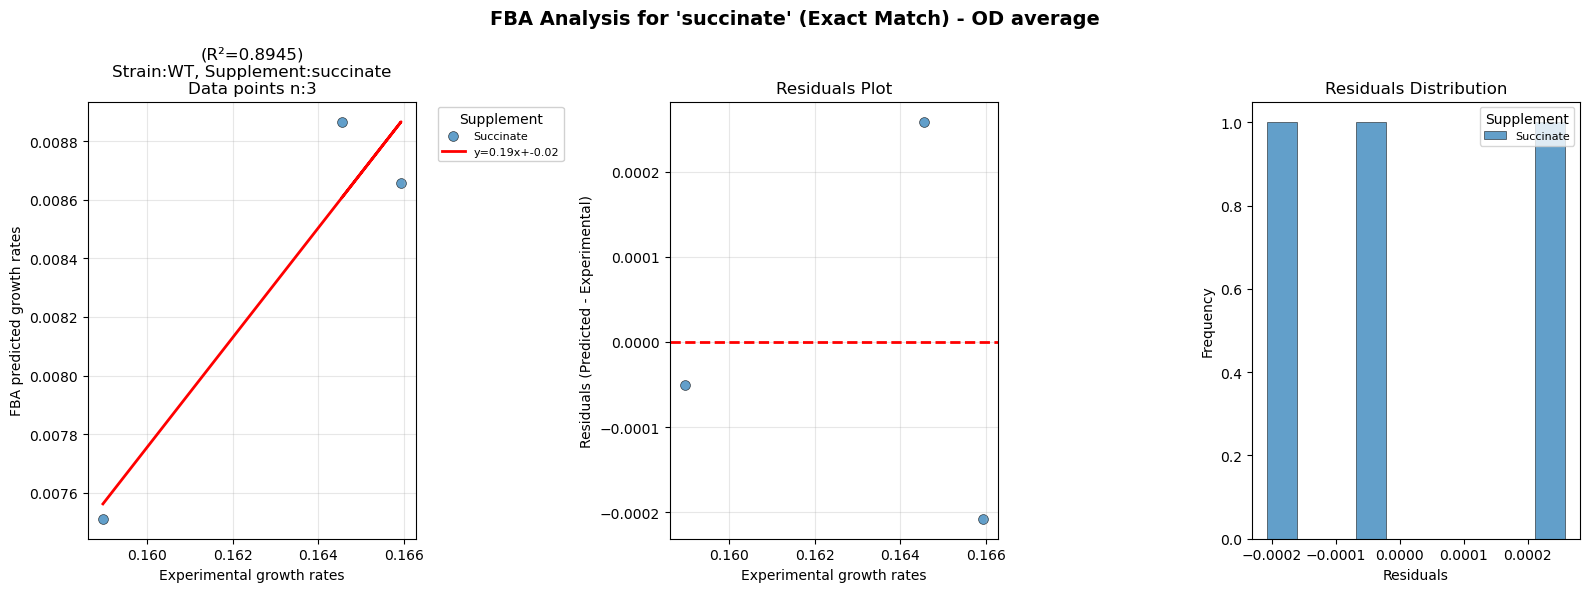

Running FBA for 10 exact matches 'glucose'


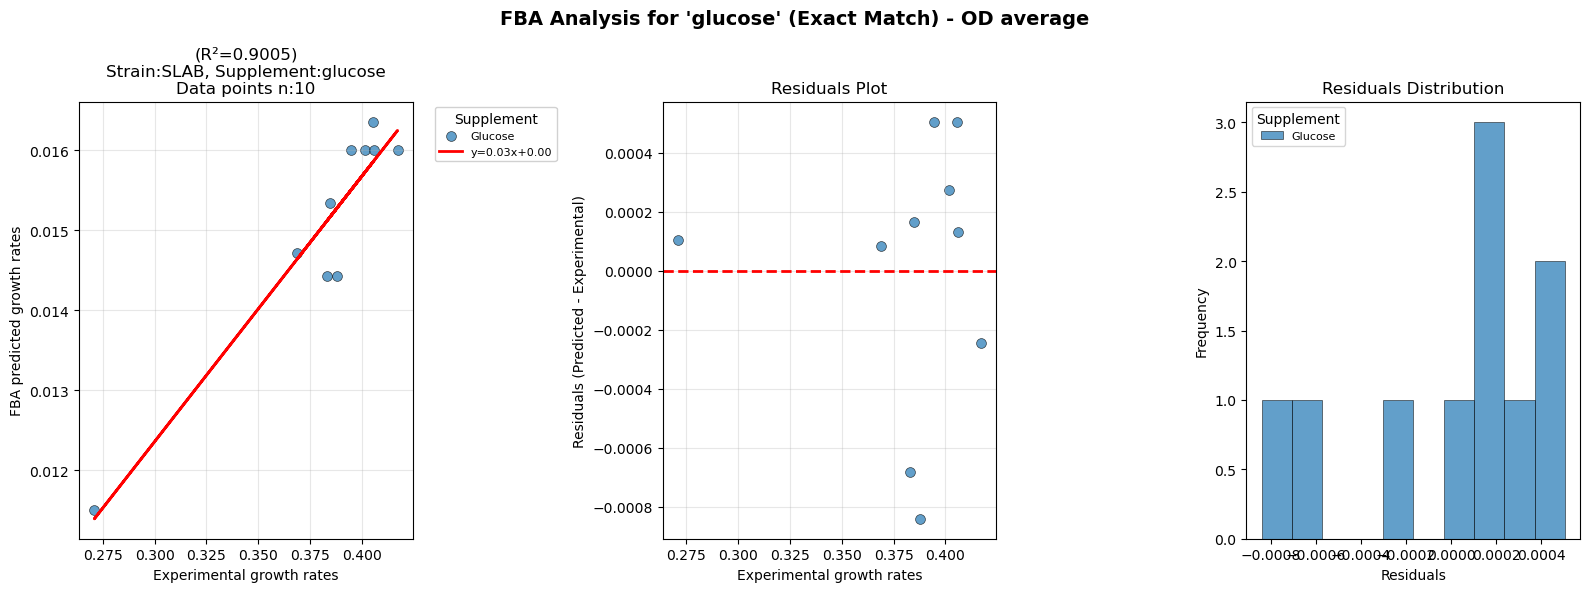

Running FBA for 3 exact matches 'succinate'


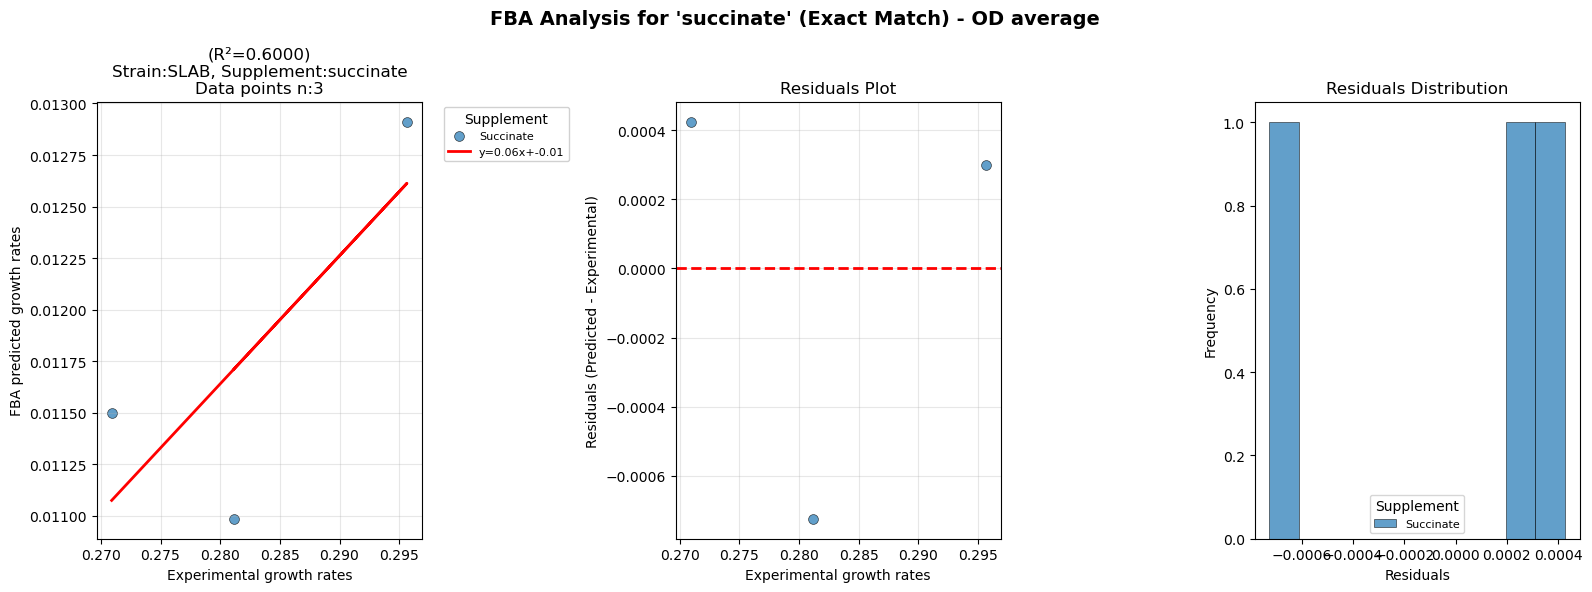

Running FBA for 10 exact matches 'glucose'


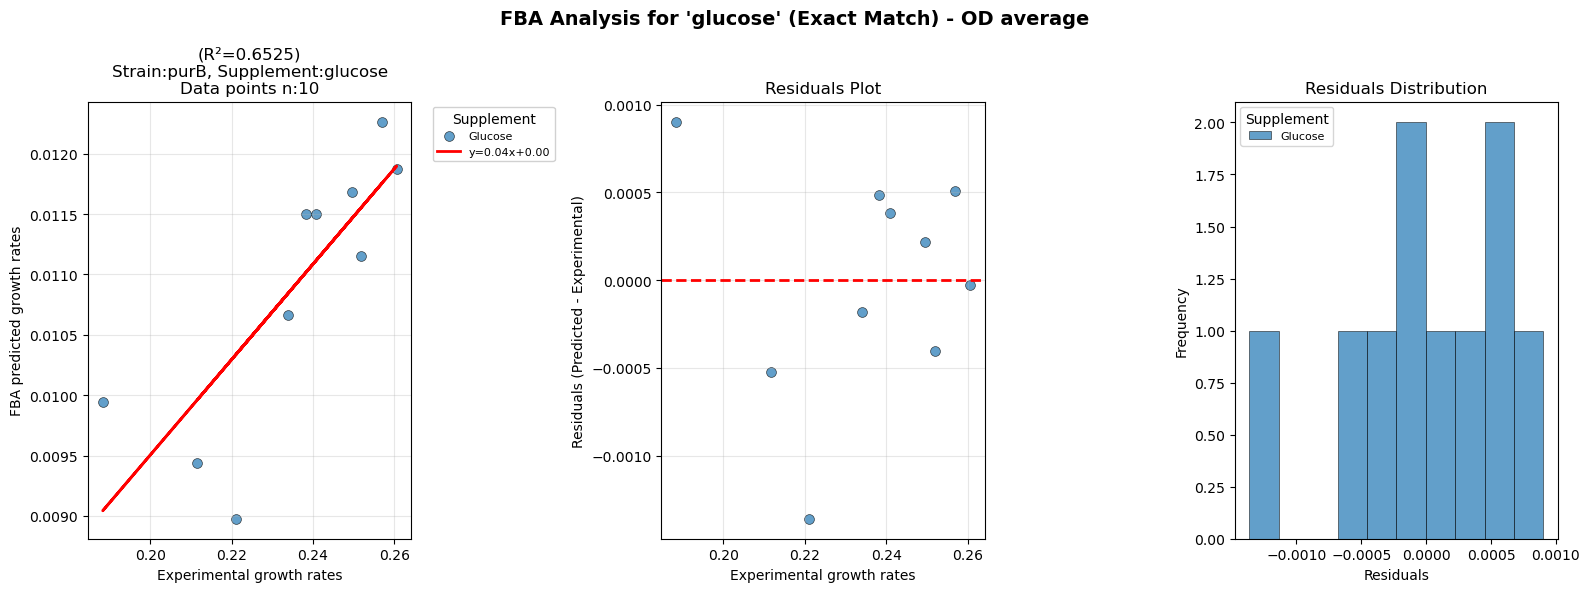

Running FBA for 3 exact matches 'succinate'


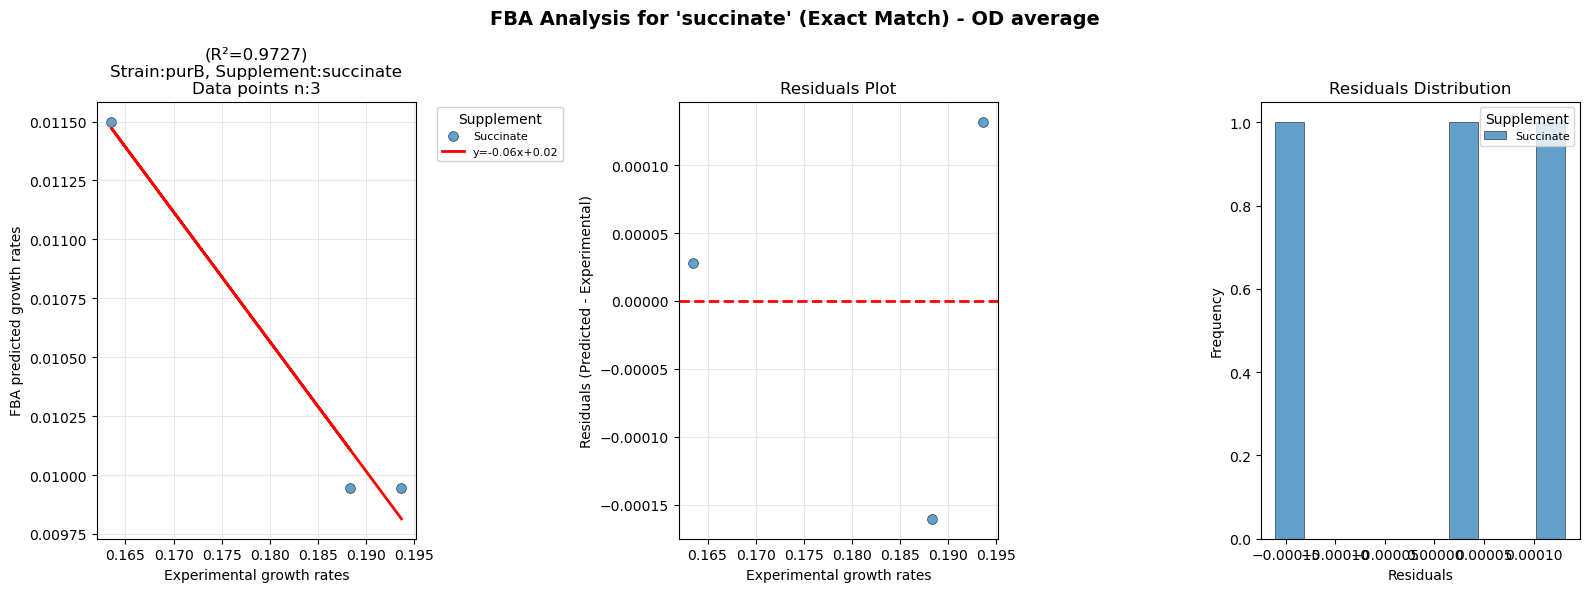

Running FBA for 10 exact matches 'glucose'


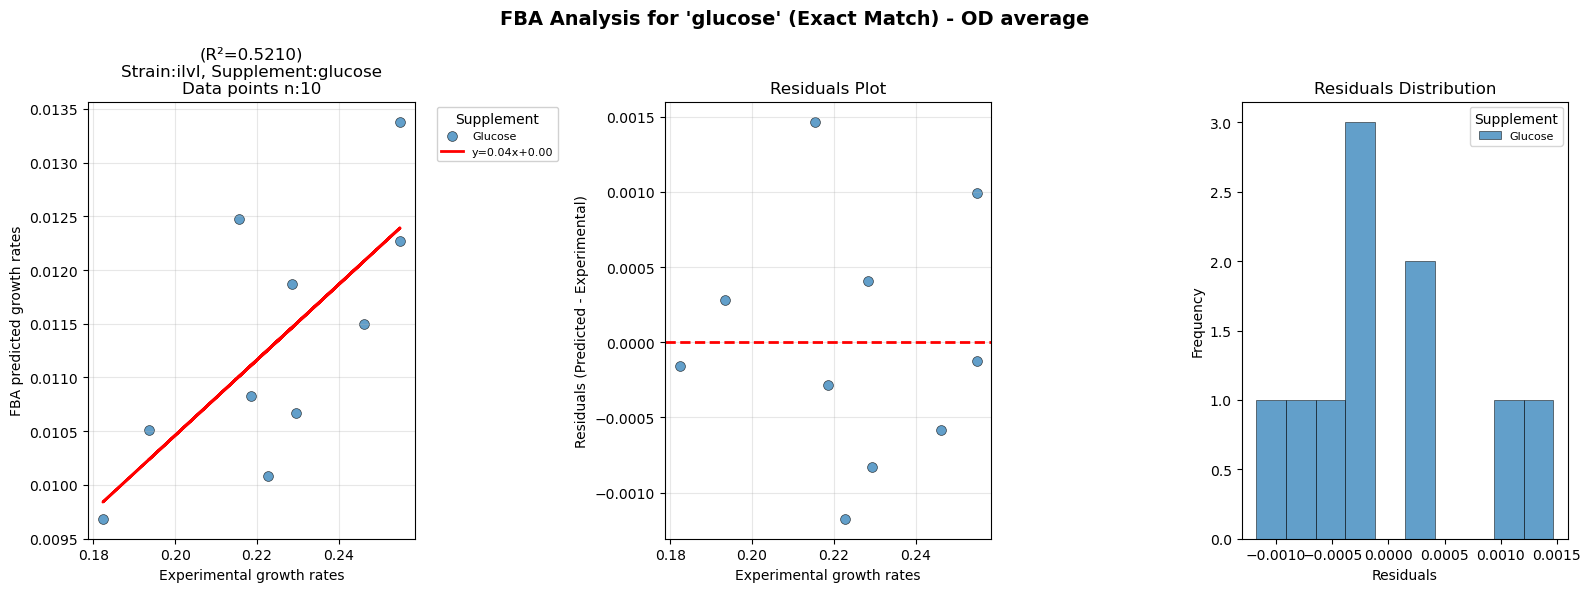

Running FBA for 3 exact matches 'succinate'


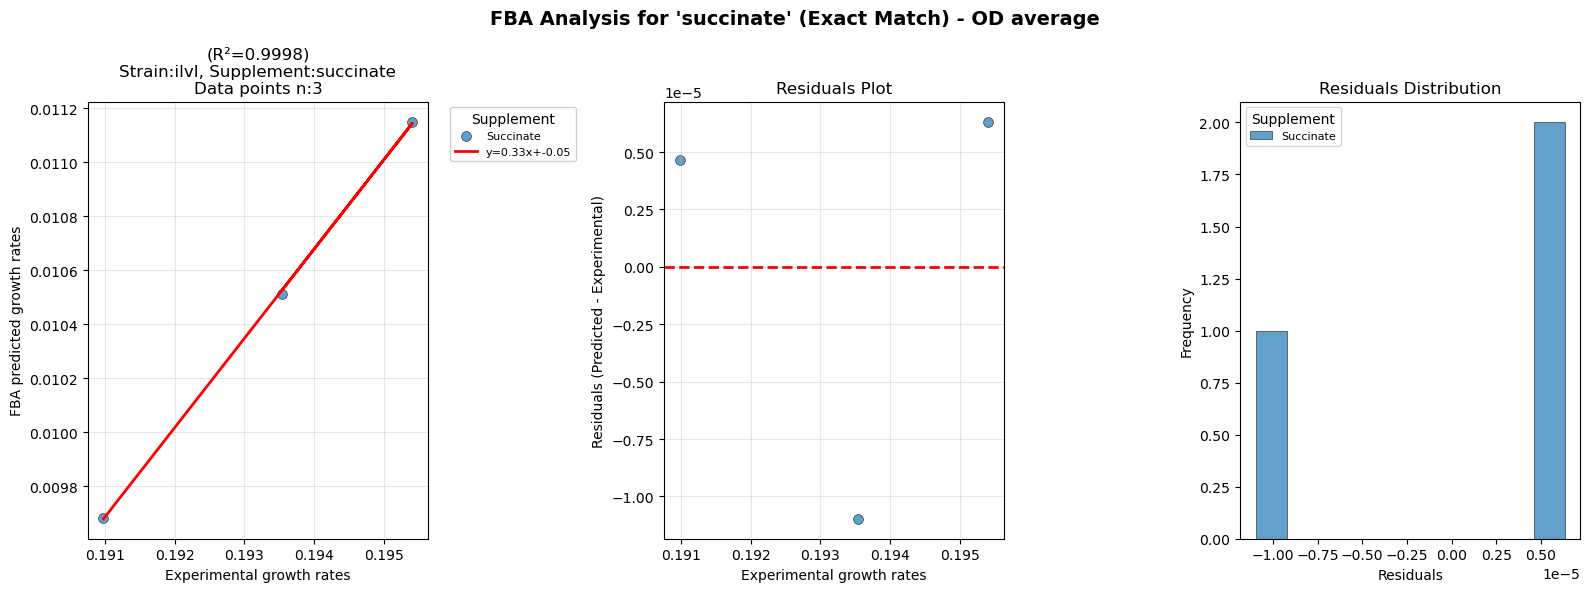

Running FBA for 10 exact matches 'glucose'


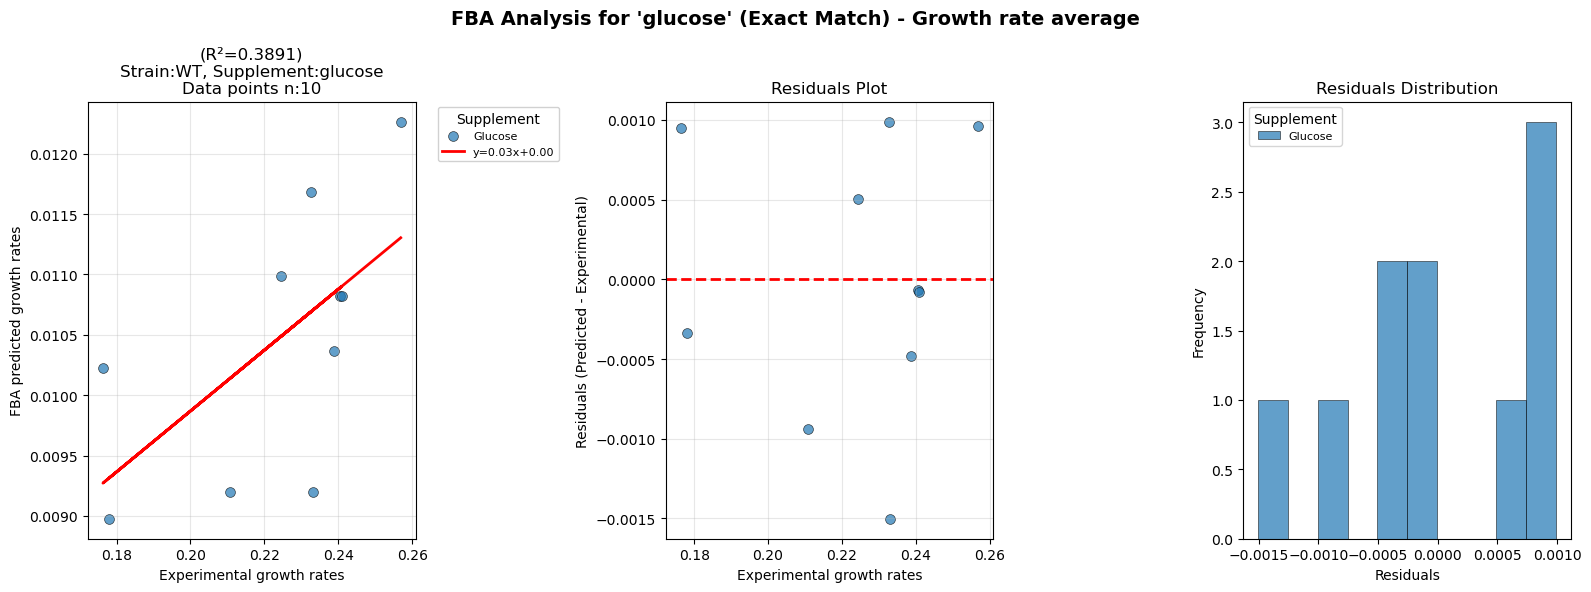

Running FBA for 3 exact matches 'succinate'


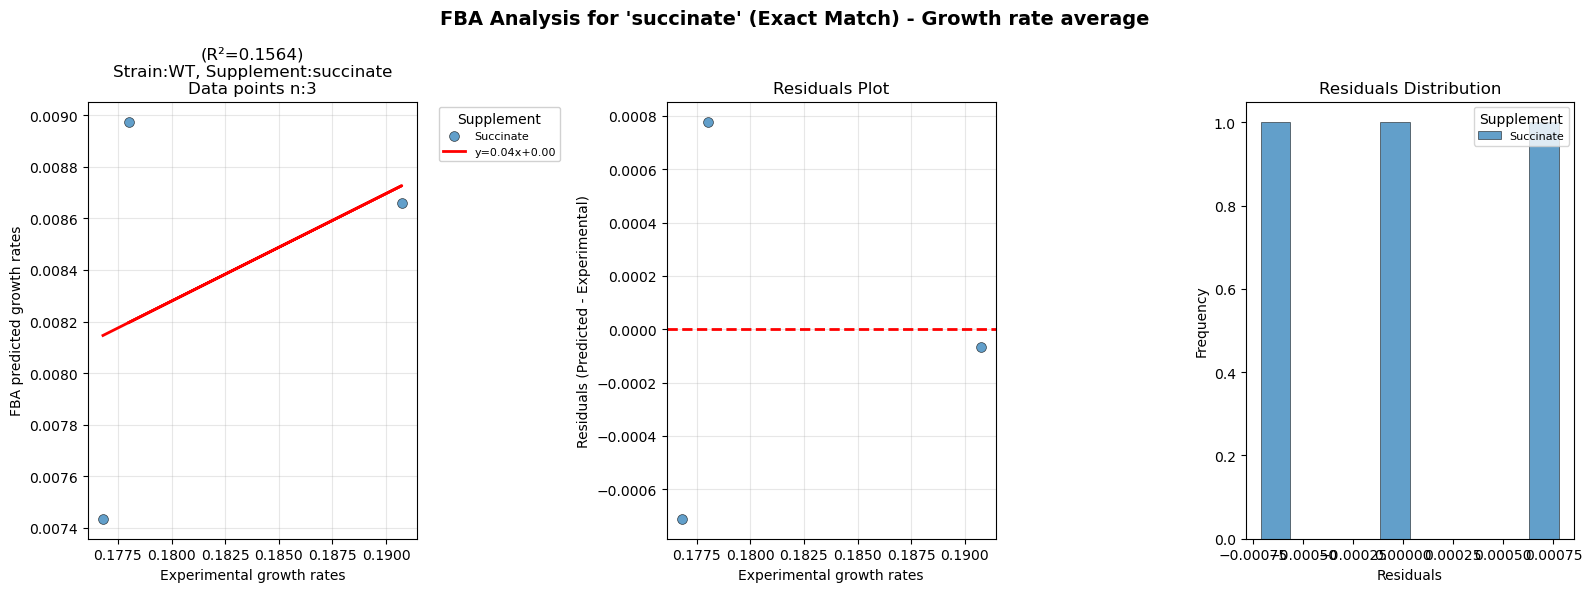

Running FBA for 10 exact matches 'glucose'


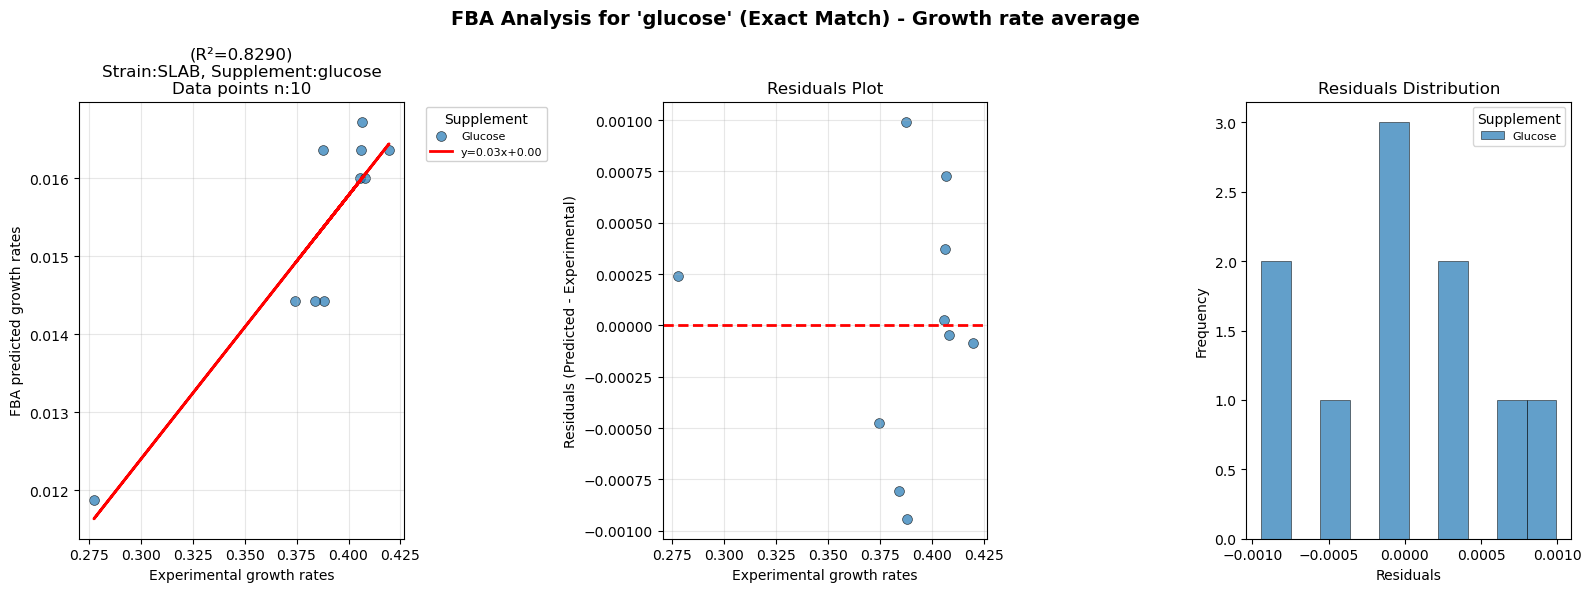

Running FBA for 3 exact matches 'succinate'


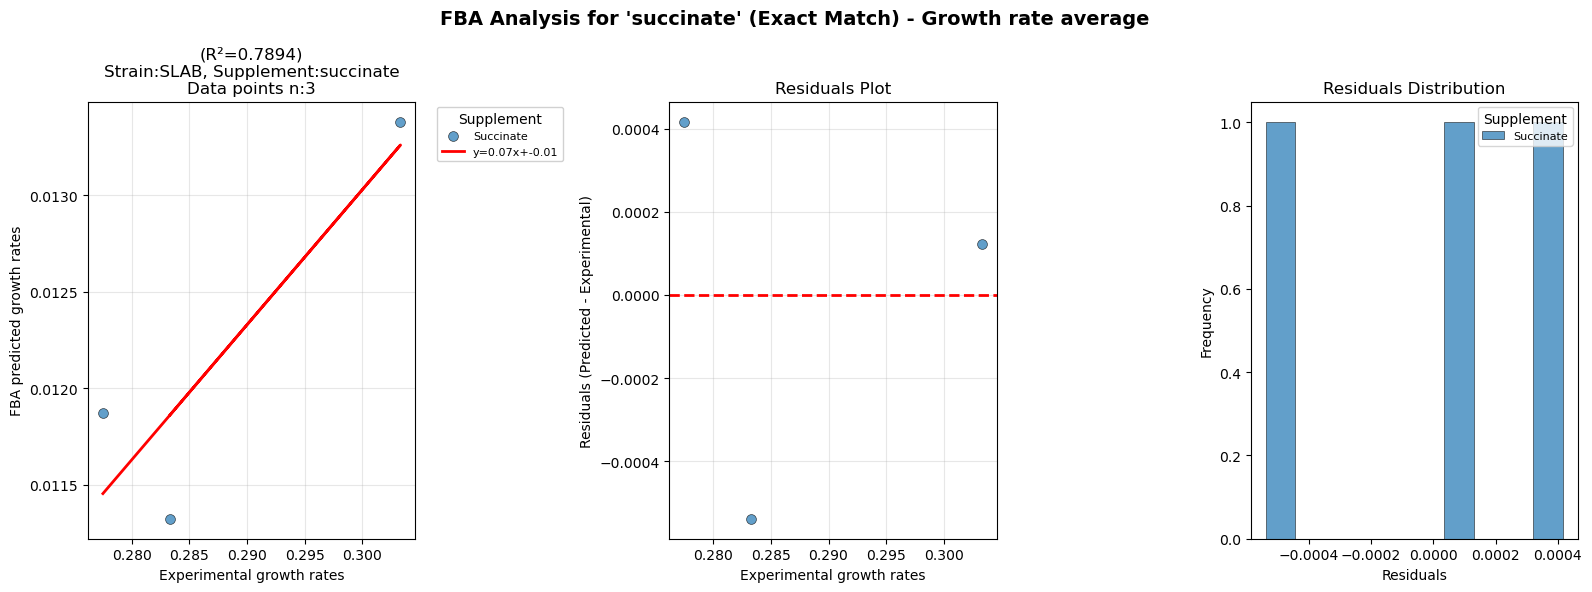

Running FBA for 10 exact matches 'glucose'


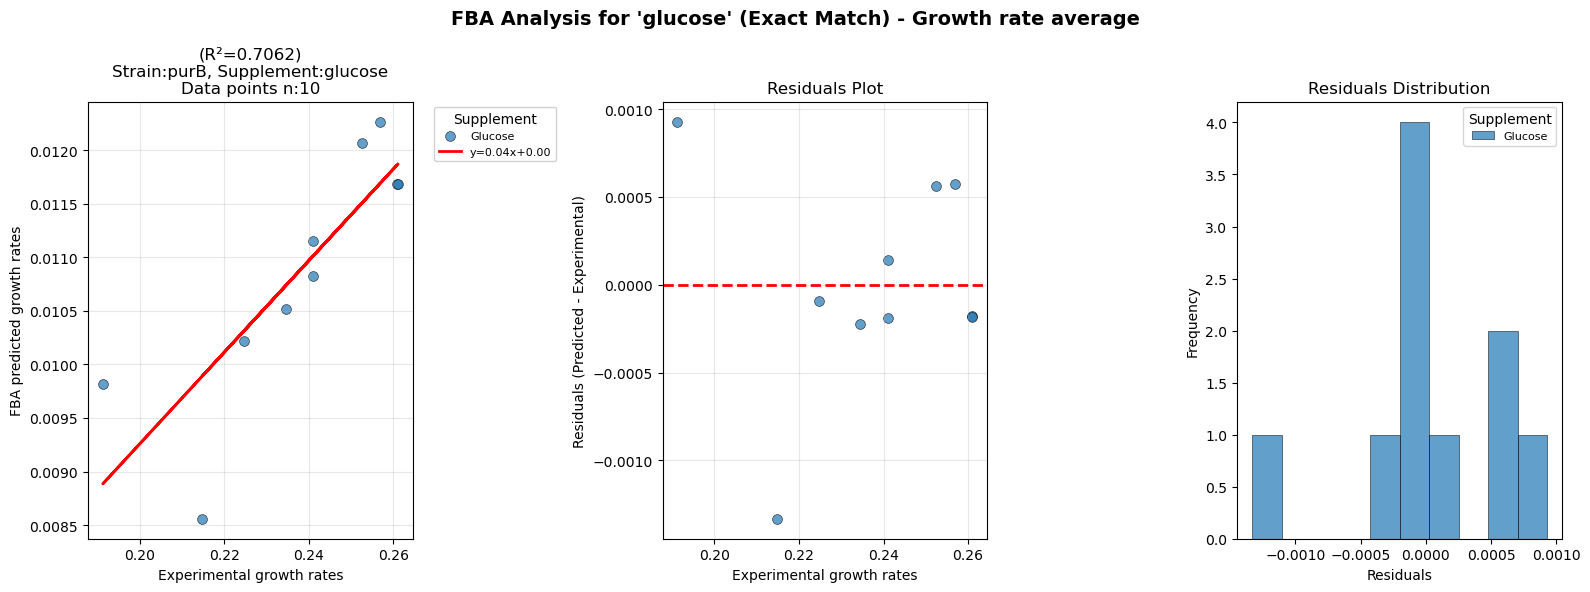

Running FBA for 2 exact matches 'succinate'


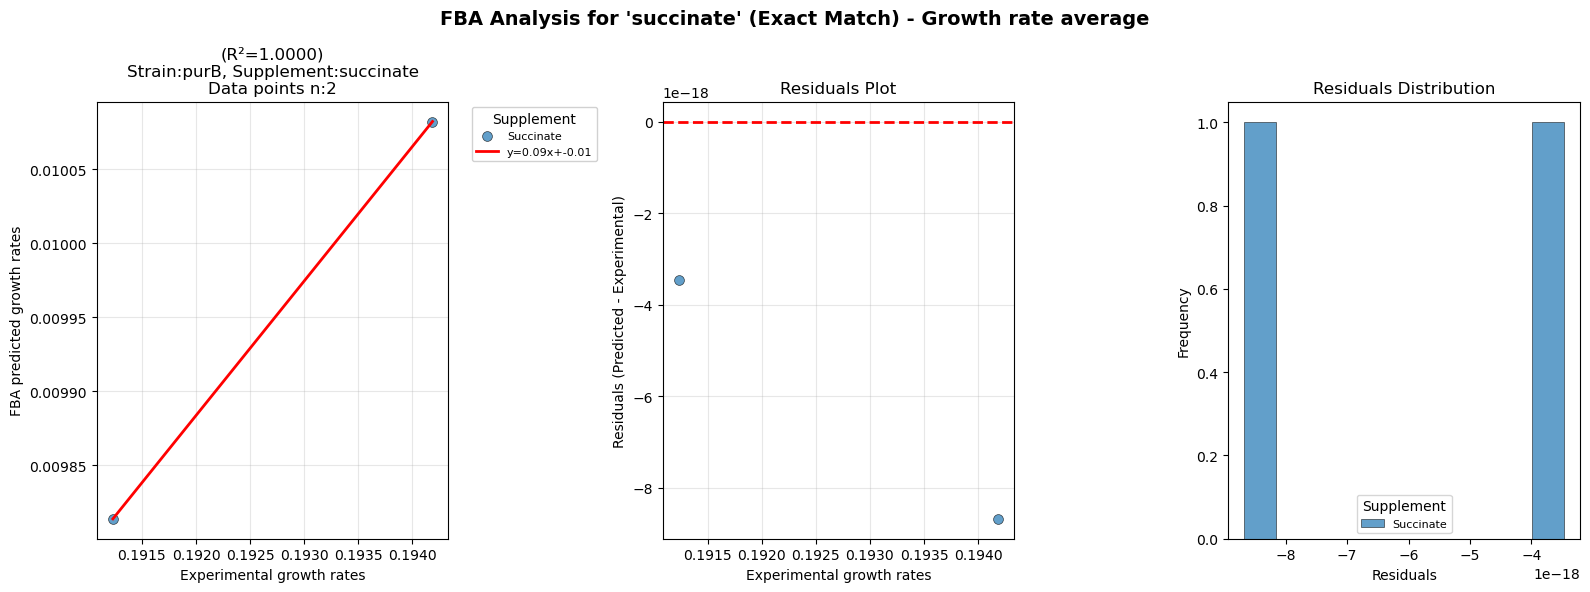

Running FBA for 10 exact matches 'glucose'


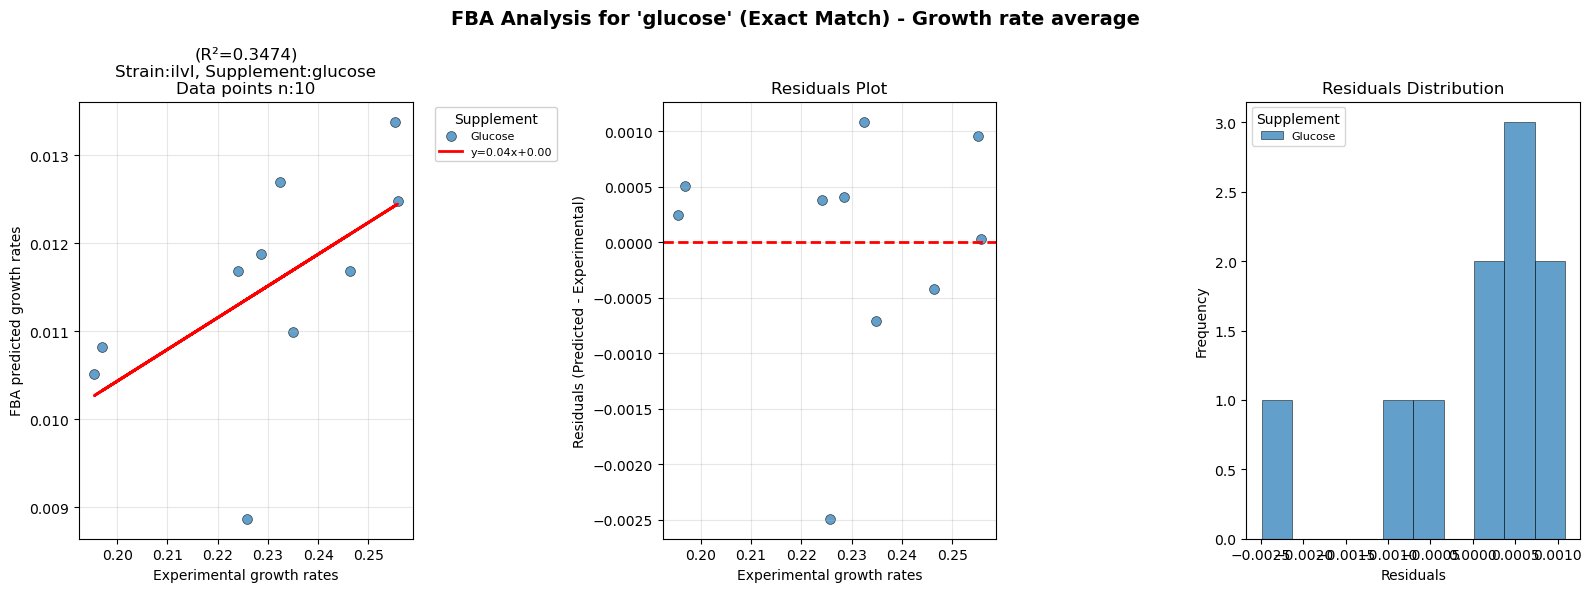

Running FBA for 3 exact matches 'succinate'


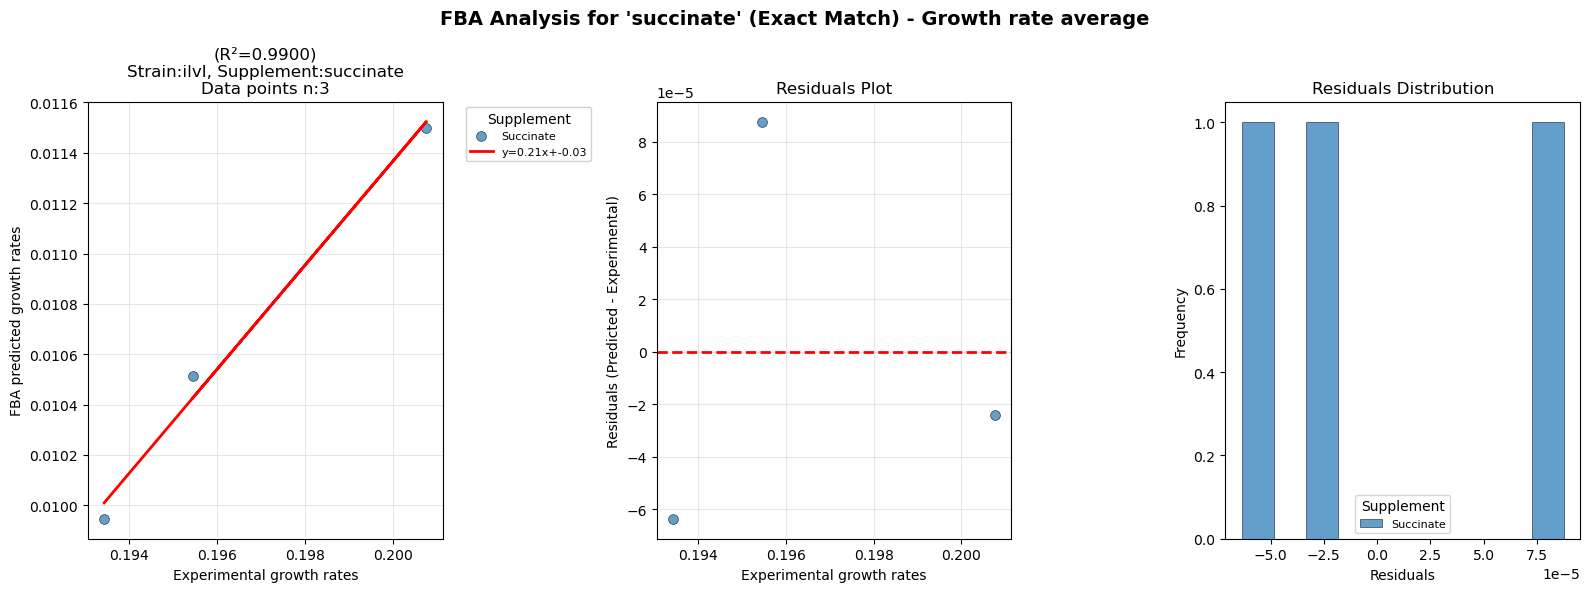

In [5]:
strains = ["WT", "SLAB", "purB", "ilvI"]
experiments = ["mediabotJLF".join(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "14"])]
replications = ["no_replicates", "replicates", "post_replicates"]
gr_columns = ["mv_mu_max", "mv_mu_max", "mv_mu_max_mean"]
for replication, gr_column in zip(replications, gr_columns):
    for strain in strains:
        run_group(per_strain=True,
            strain=strain,
            replication=replication,
            gr_column=gr_column,
            supplement_filter="glucose")
        run_group(per_strain=True,
            strain=strain,
            replication=replication,
            gr_column=gr_column,
            supplement_filter="succinate")

In [6]:
import cobra
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

def run_group_df(per_strain: bool = True,
        strain:str = "WT",
        replication:str = "no_replicates",
        gr_column:str = "mv_mu_max",
        experiment:str = "mediabotJLF2",
        supplement_filter="glucose",
        exact_match:bool = True,
        ):
    """
    Run FBA analysis for a specific supplement group and create detailed plots.
    
    Parameters:
    -----------
    supplement_filter : str
        The supplement to filter by (e.g., 'glucose', 'uracil', etc.)
    exact_match : bool
        If True, only matches exact supplement combinations (e.g., 'glucose' won't match 'glucose; Gly')
        If False, matches any supplement containing the filter string
    """
    
    if per_strain:
        exp_data_path = f"H:/ROBOT_SCIENTIST/E_coli/Growth_rates/2025-10-31-27/processed/{replication}_STRAINS/{strain}/AMN_dataset/"
        growth_data_path = f"H:/ROBOT_SCIENTIST/E_coli/Growth_rates/2025-10-31-27/processed/{replication}_STRAINS/{strain}/"
    else:
        exp_data_path = f"H:/ROBOT_SCIENTIST/E_coli/Growth_rates/2025-10-31-27/processed/{replication}/{experiment}/AMN_dataset/"
        growth_data_path = f"H:/ROBOT_SCIENTIST/E_coli/Growth_rates/2025-10-31-27/processed/{replication}/{experiment}/"
    # 
    exp_data = pd.read_csv(exp_data_path + "df_flux.csv") 
    growth_data = pd.read_csv(growth_data_path + "growth_rates.csv")
    
    # Filter growth_data to match the rows in exp_data 
    growth_data = growth_data.reset_index(drop=True)
    growth_data = growth_data.loc[growth_data['success'], :]
    exp_data = exp_data.reset_index(drop=True)        
    # Remove growth rate column from growth_data to avoid duplicates
    growth_data = growth_data.drop(columns=[gr_column])                
    # Now join them - they should have the same number of rows
    combinded_data = pd.concat([exp_data.reset_index(drop=True), growth_data.reset_index(drop=True)],
                                axis=1)

    def update_uracil(val):
        for part in ["_0.5", "_22.4", "_200", "_2", "_8", "_64", "_640", "0"]:
             val = val.replace(part, "")
        return val
    combinded_data["supplements_unified"] = combinded_data["supplements"].apply(lambda x: update_uracil(str(x)) if pd.notna(x) else x)
    
    def classify(val):
        """Classify supplements into Sugar, Nucleo, Amino based on content"""
        if pd.isna(val) or str(val).lower() == 'nan' or str(val).strip() == '':
            return 'None'
        
        # Split by semicolon and convert to lowercase for comparison
        parts = str(val).lower().split(';')
        parts = [p.strip() for p in parts if p.strip()]
        
        if not parts:
            return 'None'
        
        # Define categories (all lowercase)
        sugars = ['glucose', 'succinate', 'sucrose', 'galactose', 'fructose', 'mannose',
                  'maltose', 'lactose', 'xylose', 'arabinose', 'ribose']
        
        nucleobases = ['adenine', 'uracil', 'guanine', 'cytosine', 'thymine']
        
        # Amino acids are typically 3 letters (all lowercase)
        amino_acids_3letter = ['ala', 'arg', 'asn', 'asp', 'cys', 'gln', 'glu', 'gly',
                               'his', 'ile', 'leu', 'lys', 'met', 'phe', 'pro', 'ser',
                               'thr', 'trp', 'tyr', 'val']
        
        categories = []
        for part in parts:
            # Check if it's a sugar
            if any(sugar in part for sugar in sugars):
                if 'Sugar' not in categories:
                    categories.append('Sugar')
            # Check if it's a nucleobase
            elif any(nucleo in part for nucleo in nucleobases):
                if 'Nucleo' not in categories:
                    categories.append('Nucleo')
            # Check if it's a 3-letter amino acid or contains common amino acid patterns
            elif any(aa in part for aa in amino_acids_3letter) or len(part) == 3:
                if 'Amino' not in categories:
                    categories.append('Amino')
        
        if not categories:
            return 'Other'
        
        # Sort to ensure consistent ordering
        categories.sort()
        return '+'.join(categories)
    
    combinded_data["group"] = combinded_data["supplements_unified"].apply(classify)
    
    # FILTER DATA BEFORE FBA - This is the key fix!
    if exact_match:
        # Exact match: case-insensitive comparison of the entire supplement string
        supplement_mask = combinded_data['supplements_unified'].astype(str).str.lower() == supplement_filter.lower()
    else:
        # Contains match: finds any supplement containing the filter string
        supplement_mask = combinded_data['supplements_unified'].astype(str).str.lower().str.contains(supplement_filter.lower(), na=False)
    
    if not supplement_mask.any():
        match_type = "exactly matching" if exact_match else "containing"
        print(f"No data found for supplement {match_type} '{supplement_filter}'")
        return
    
    # Filter both exp_data and combinded_data    
    combinded_data_filtered = combinded_data[supplement_mask].reset_index(drop=True)
    
    match_type = "exact matches" if exact_match else "samples containing"    
    
    
    
    
    # Get individual supplements for color coding
    supplements = combinded_data_filtered['supplements_unified'].values
    unique_supps = np.unique(supplements)


    return combinded_data_filtered.loc[combinded_data_filtered['supplements_unified'].isin(unique_supps), :]
    


Running FBA for 10 exact matches 'glucose'


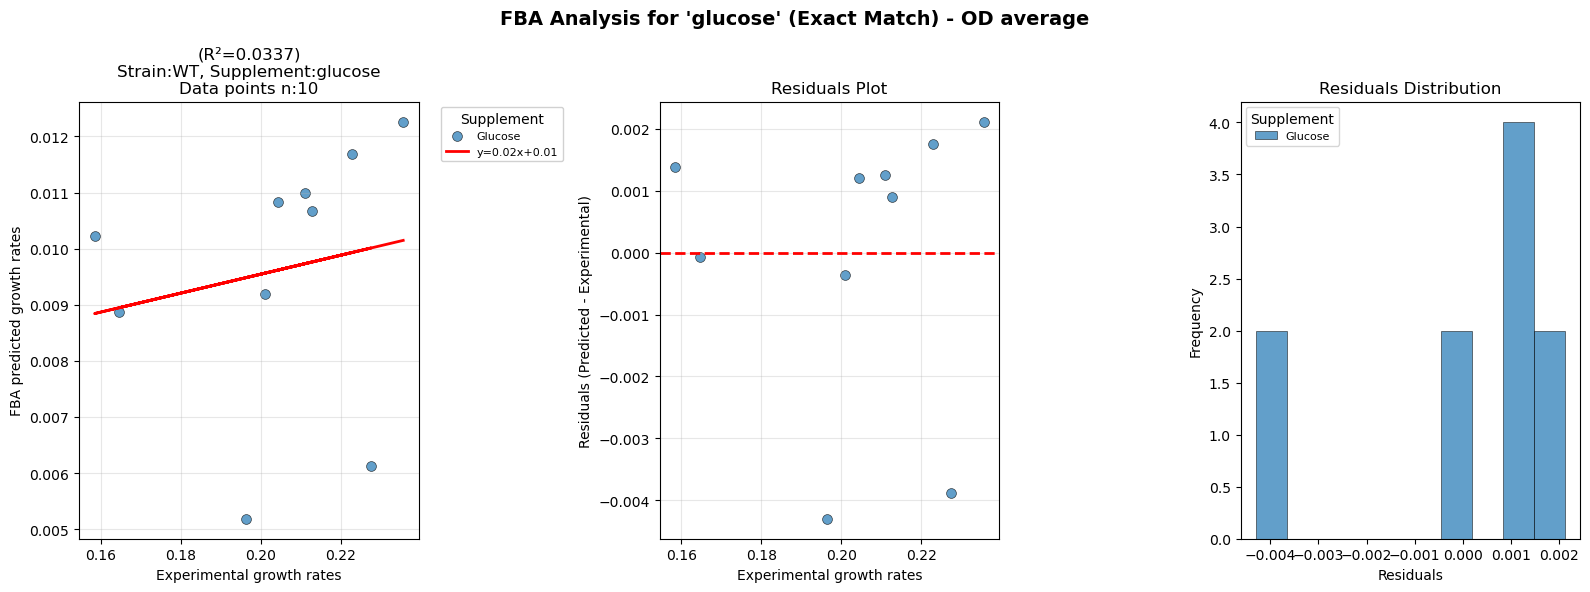

wells  success     experiment supplements supplements_unified  group
0  A10,A11,A12     True   mediabotJLF1     Glucose             Glucose  Sugar
1  A10,A11,A12     True  mediabotJLF10     Glucose             Glucose  Sugar
2  A10,A11,A12     True  mediabotJLF11     Glucose             Glucose  Sugar
3  A10,A11,A12     True  mediabotJLF12     Glucose             Glucose  Sugar
4  A10,A11,A12     True  mediabotJLF14     Glucose             Glucose  Sugar
5  A10,A11,A12     True   mediabotJLF2     Glucose             Glucose  Sugar
6  H10,H11,H12     True   mediabotJLF5     Glucose             Glucose  Sugar
7  H10,H11,H12     True   mediabotJLF6     Glucose             Glucose  Sugar
8  A10,A11,A12     True   mediabotJLF7     Glucose             Glucose  Sugar
9  A10,A11,A12     True   mediabotJLF8     Glucose             Glucose  Sugar

In [7]:
run_group(per_strain=True,
            strain="WT",
            replication="replicates",
            gr_column="mv_mu_max",
            supplement_filter="glucose")#succinate
df = run_group_df(per_strain=True,
            strain="WT",
            replication="replicates",
            gr_column="mv_mu_max",
            supplement_filter="glucose")#succinate
df[['wells', 'success', 'experiment',  'supplements', 'supplements_unified', 'group']]

Running FBA for 10 exact matches 'glucose'


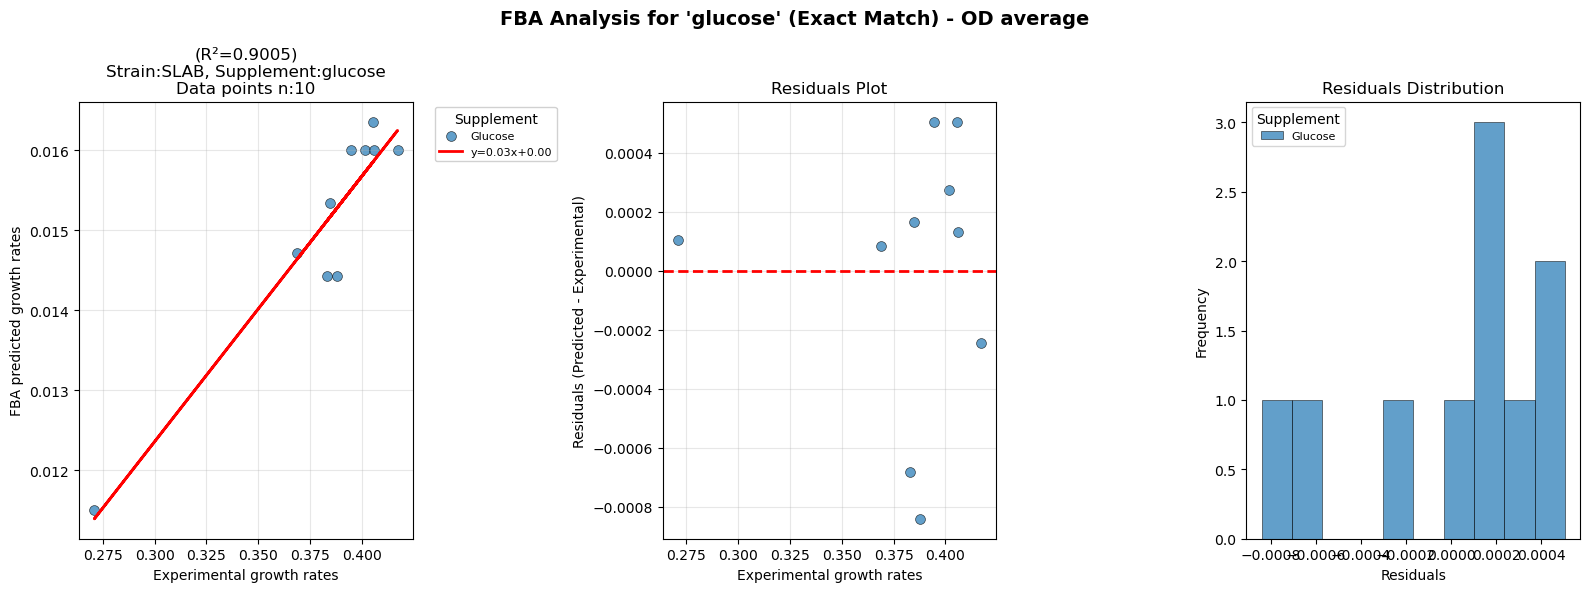

wells  success     experiment supplements supplements_unified  group
0  A1,A2,A3     True   mediabotJLF1     Glucose             Glucose  Sugar
1  A1,A2,A3     True  mediabotJLF10     Glucose             Glucose  Sugar
2  A1,A2,A3     True  mediabotJLF11     Glucose             Glucose  Sugar
3  A1,A2,A3     True  mediabotJLF12     Glucose             Glucose  Sugar
4  A1,A2,A3     True  mediabotJLF14     Glucose             Glucose  Sugar
5  A1,A2,A3     True   mediabotJLF2     Glucose             Glucose  Sugar
6  H1,H2,H3     True   mediabotJLF5     Glucose             Glucose  Sugar
7  H1,H2,H3     True   mediabotJLF6     Glucose             Glucose  Sugar
8  A1,A2,A3     True   mediabotJLF7     Glucose             Glucose  Sugar
9  A1,A2,A3     True   mediabotJLF8     Glucose             Glucose  Sugar

In [8]:
run_group(per_strain=True,
            strain="SLAB",
            replication="replicates",
            gr_column="mv_mu_max",
            supplement_filter="glucose")#succinate
df = run_group_df(per_strain=True,
            strain="SLAB",
            replication="replicates",
            gr_column="mv_mu_max",
            supplement_filter="glucose")#succinate
df[['wells', 'success', 'experiment',  'supplements', 'supplements_unified', 'group']]